In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime,date

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
us_covid_with_dates = pd.read_pickle('../datasets/us_covid_with_dates.pkl')

In [4]:
us_covid_with_dates

2020-01-21 00:00:00  2020-01-22 00:00:00  \
state                                                            
Alabama                                 0                  0.0   
Alaska                                  0                  0.0   
Arizona                                 0                  0.0   
California                              0                  0.0   
Colorado                                0                  0.0   
Connecticut                             0                  0.0   
Delaware                                0                  0.0   
District of Columbia                    0                  0.0   
Florida                                 0                  0.0   
Georgia                                 0                  0.0   
Hawaii                                  0                  0.0   
Idaho                                   0                  0.0   
Illinois                                0                  0.0   
Indiana                                 0                  0.0   
Kansas                                  0                  0.0   
Kentucky                                0                  0.0   
Louisiana                               0                  0.0   
Maine                                   0                  0.0   
Maryland                                0                  0.0   
Massachusetts                           0                  0.0   
Michigan                                0                  0.0   
Minnesota                               0                  0.0   
Mississippi                             0                  0.0   
Missouri                                0                  0.0   
Montana                                 0                  0.0   
Nevada                                  0                  0.0   
New Hampshire                           0                  0.0   
New Jersey                              0                  0.0   
New Mexico                              0                  0.0   
New York                                0                  0.0   
North Carolina                          0                  0.0   
Ohio                                    0                  0.0   
Oregon                                  0                  0.0   
Pennsylvania                            0                  0.0   
Rhode Island                            0                  0.0   
Tennessee                               0                  0.0   
Texas                                   0                  0.0   
Vermont                                 0                  0.0   
Virginia                                0                  0.0   
Washington                              0                  0.0   
West Virginia                           0                  0.0   
Wisconsin                               0                  0.0   

                      2020-01-23 00:00:00  2020-01-24 00:00:00  \
state                                                            
Alabama                               0.0                  0.0   
Alaska                                0.0                  0.0   
Arizona                               0.0                  0.0   
California                            0.0                  0.0   
Colorado                              0.0                  0.0   
Connecticut                           0.0                  0.0   
Delaware                              0.0                  0.0   
District of Columbia                  0.0                  0.0   
Florida                               0.0                  0.0   
Georgia                               0.0                  0.0   
Hawaii                                0.0                  0.0   
Idaho                                 0.0                  0.0   
Illinois                              0.0                  0.0   
Indiana                               0.0                  0.0   
Kansas                                0.0                  0.

In [105]:
class State():
    
    def __init__(self, percent_increases, dates, name):
        '''
        percent_increases: floats with last entry being date in 
                                which the stay-at-home order was effective.
        dates: pandas._libs.tslibs.timestamps.Timestamp with last 
                    entry being 'Effective Date'
        '''
        self.percent_increases = self.parse_increases(percent_increases)
        self.dates = self.parse_dates(dates, percent_increases)
        self.name = name
        self.stay_home_date = self.stay_home(percent_increases)
        self.random_color = random_color = np.random.rand(3,)
        self.p_value = self.calc_p_value()
    
    def parse_increases(self, perc_inc):
        '''Returns only the percent increases (takes away 0's and the 
        effective date)'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the percent increases that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        return perc_greater
    
    def parse_dates(self, date, perc_inc):
        '''Returns only the days that have percent increases'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the data that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        #strip dates of last entry
        date_ = date[:-1]
        
        #get only the dates that the perc_inc is more than 0
        dates_greater = date_[perc_inc_ > 0]
        
        return dates_greater
    
    def stay_home(self, perc_inc):
        '''Returns the day at which the state implemented stay-at-home order'''
        return perc_inc[-1]
    
    def plot_percent_changes(self, ax):
        '''Plots the percent increase per day
        and plots a vertical line at the stay_home_date in the same color'''
        ax.plot(self.dates, self.percent_increases, c=self.random_color,
                label=self.name)
        
        ax.axvline(self.stay_home_date, linestyle="--", c=self.random_color,
                  label = '{} Stay-Home Date'.format(self.name))

        
    # Hypothesis Testing
    def get_pre_increase(self):
        '''Returns only the data before social distancing was implented plus
        7 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        try:
            index_social = list(self.dates).index(federal_dist_date)
        except ValueError:
            index_social = 0
        
        return self.percent_increases[:index_social + 7]
    
    def get_post_increase(self):
        '''Returns only the data after social distancing was implented plus
        8 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        try:
            index_social = list(self.dates).index(federal_dist_date)
        except ValueError:
            index_social = 0
        
        return self.percent_increases[index_social + 8:]
    
    def calc_p_value(self):
        stat, p_val = stats.ttest_ind(self.get_pre_increase(), 
                                      self.get_post_increase(), 
                                      equal_var = False)
        return p_val
    
    def plot_p_value(self, ax):
        '''Plots the p-value for the state on a bar chart per day
        and plots a horizontal line at the rejection threshold (0.05)'''
        
        ax.bar(self.name, self.p_value, label="{} p-value".format(self.name), 
               color= self.random_color, alpha=0.3)
        ax.axhline(0.05, linestyle="--", color="red", 
                 label='Rejection Threshold')
        #ax.set_xlabel(self.name)
        ax.legend()

In [128]:
def generate_labels(ax):
    '''generates labels and formats axes'''
    ax.legend(fontsize=14)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 4))
    ax.set_xlabel('Date')
    ax.xaxis.label.set_size(20)
    
    
    ax.set_ylabel('Percent Change Per Day')
    ax.yaxis.label.set_size(20)

In [79]:
def plot_social_distance(ax, date):
    '''Plots vertical line on axis that shows the date at which social distancing was implemented.
    Inputs
    ------
    ax: matplotlib ax to plot on
    dates: pandas._libs.tslibs.timestamps.Timestamp with last entry being 'Effective Date'
    label: string
    
    Returns
    -------
    None   
    
    '''
    ax.axvline(date, color="green", linestyle="--", 
               label='Federal Social Distancing Date')

In [80]:
def get_social_distance_date():
    federal_dist_date = '2020-03-16'
    federal_dist_date = pd.to_datetime(federal_dist_date)
    return federal_dist_date

## Make a list of State objects

In [106]:
all_states = []

for each_state in us_covid_with_dates.index:
    each_state = State(us_covid_with_dates.loc[each_state, :], 
                   us_covid_with_dates.columns, each_state)
    all_states.append(each_state)

In [82]:
length = len(all_states)

### Plot every state on one plot, each with its own subplot. save it to a file

In [83]:
# fig, axs = plt.subplots(length, 2, figsize=(16,200), sharex = False, sharey = False)

# ax = axs.flatten()

# i=0 #counter for the axes

# #plot line graph on the first part of the plot
# for each_state in all_states:
    
#     #plot percent change
#     each_state.plot_percent_changes(ax[i])
#     plot_social_distance(ax[i], get_social_distance_date())
#     generate_labels(ax[i])
    
#     #plot bar graph next to percent change
#     each_state.plot_p_value(ax[i+1])
    
#     i+=2
    
# fig.tight_layout()

# plt.savefig('all_states_with_p_value.png')

### Plot every state on its own plot. save each to a file.

/Users/tjwoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


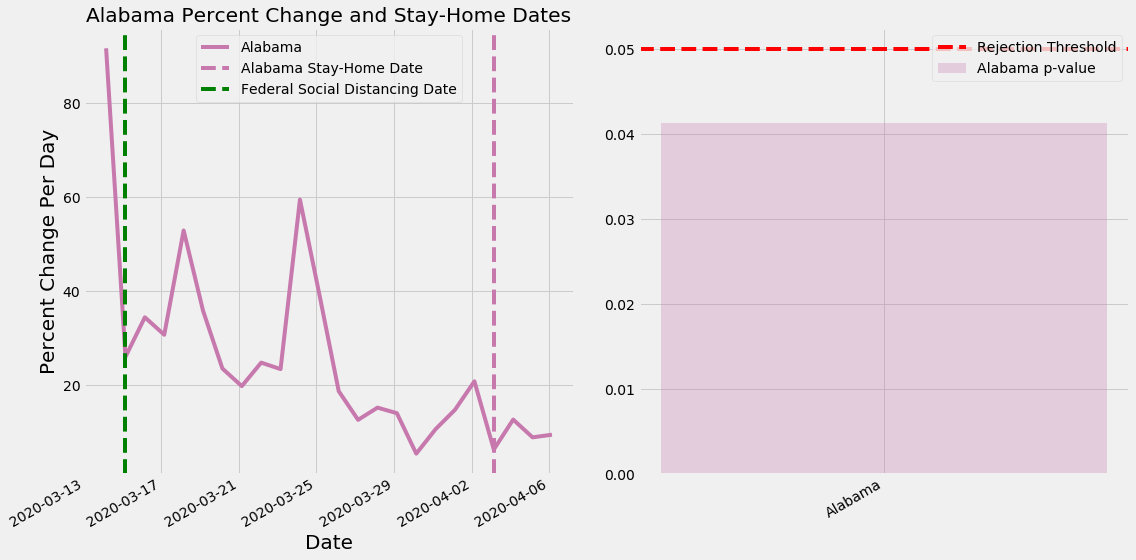

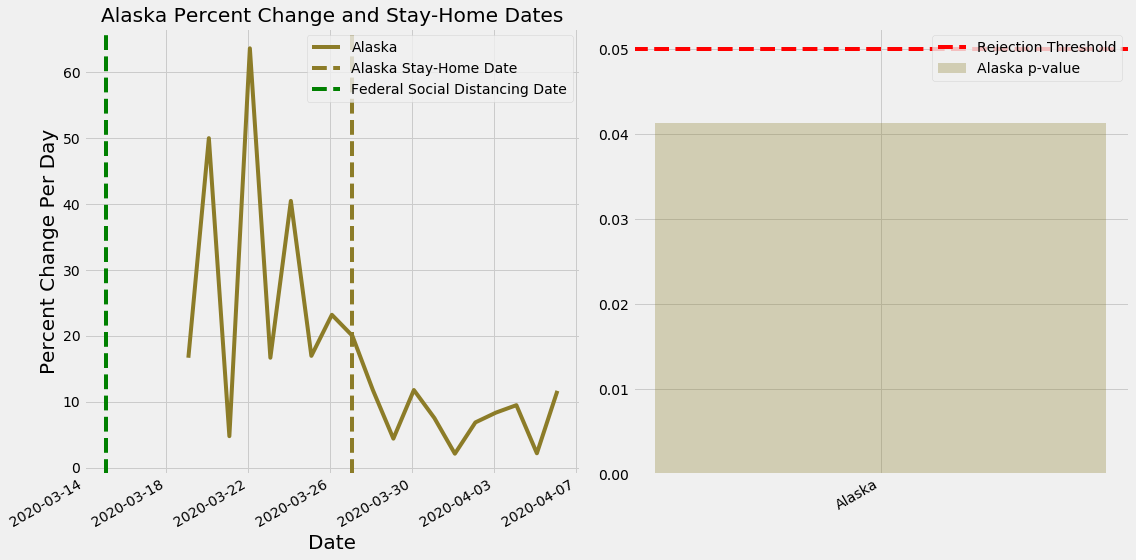

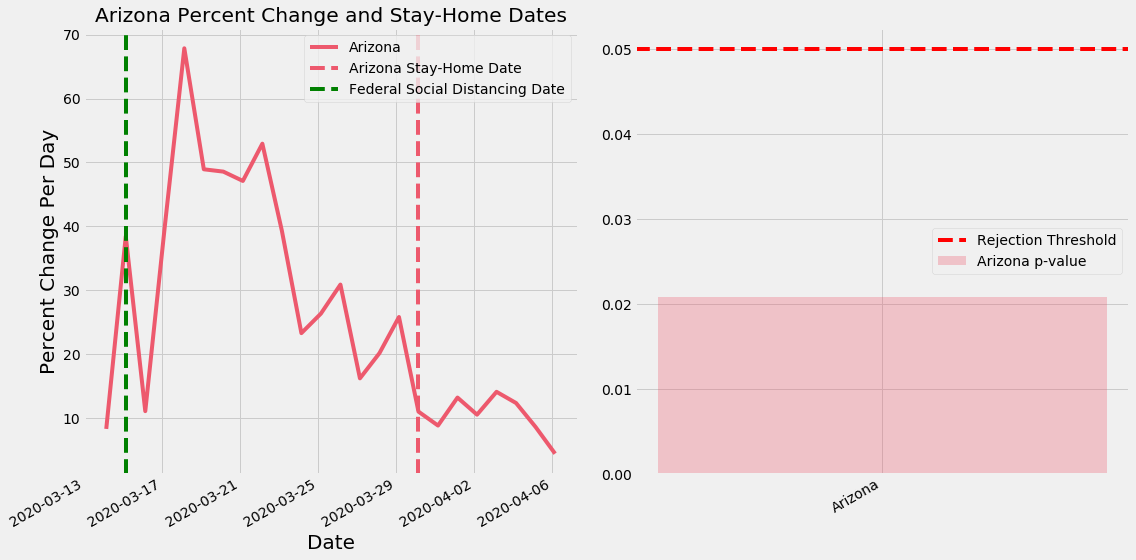

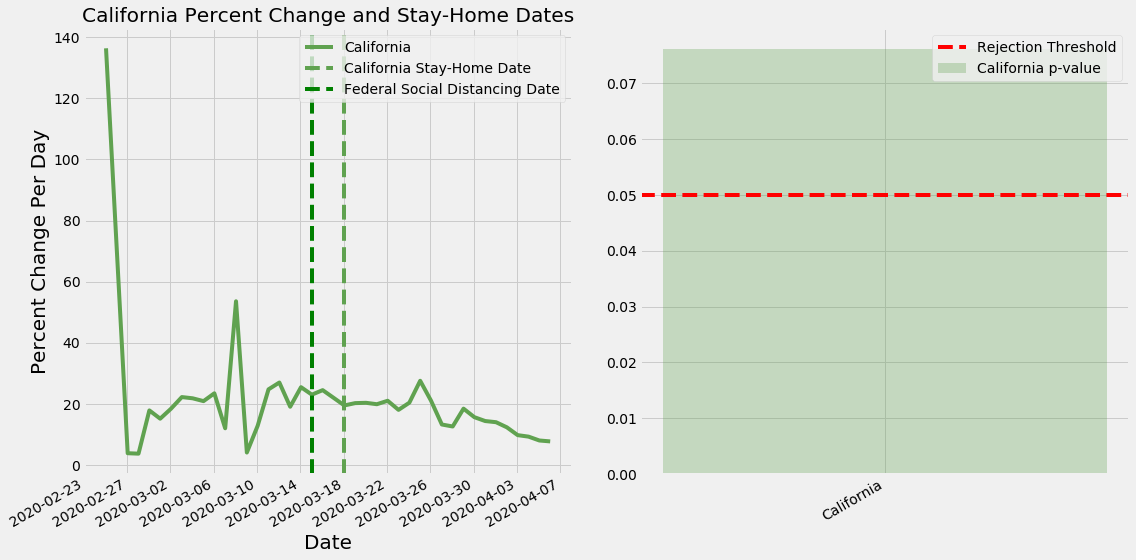

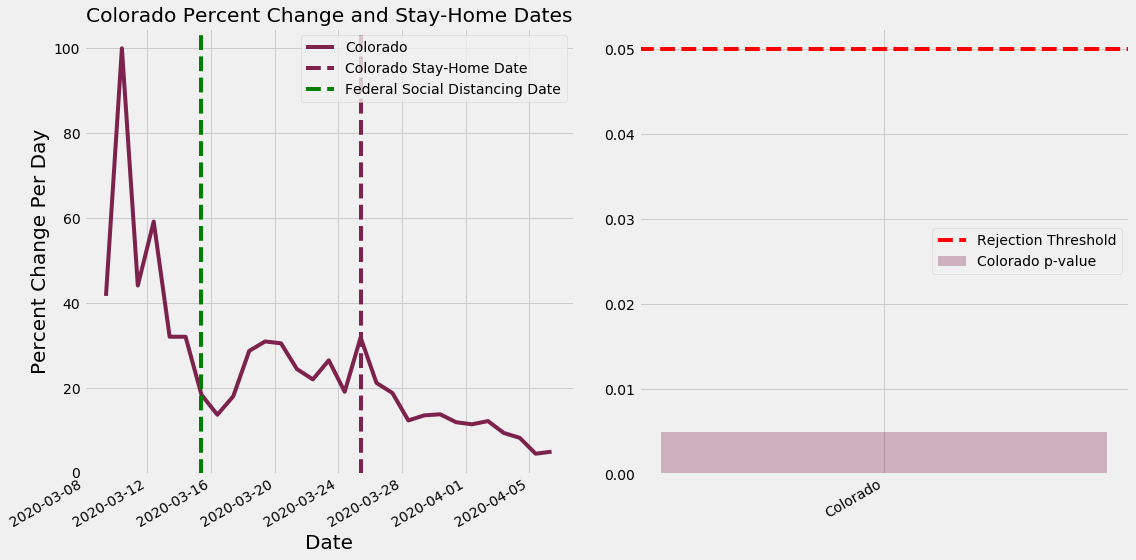

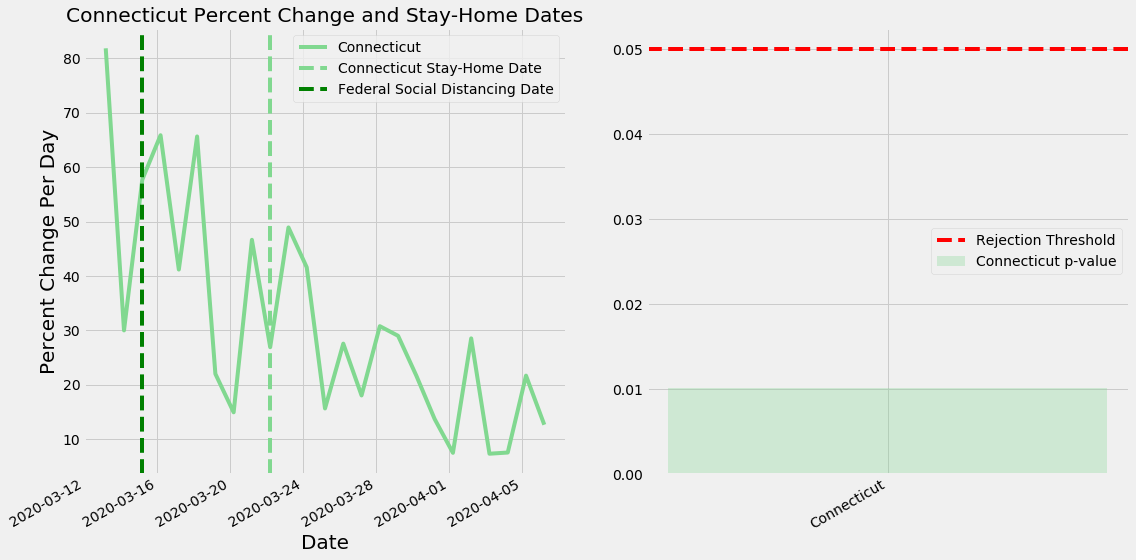

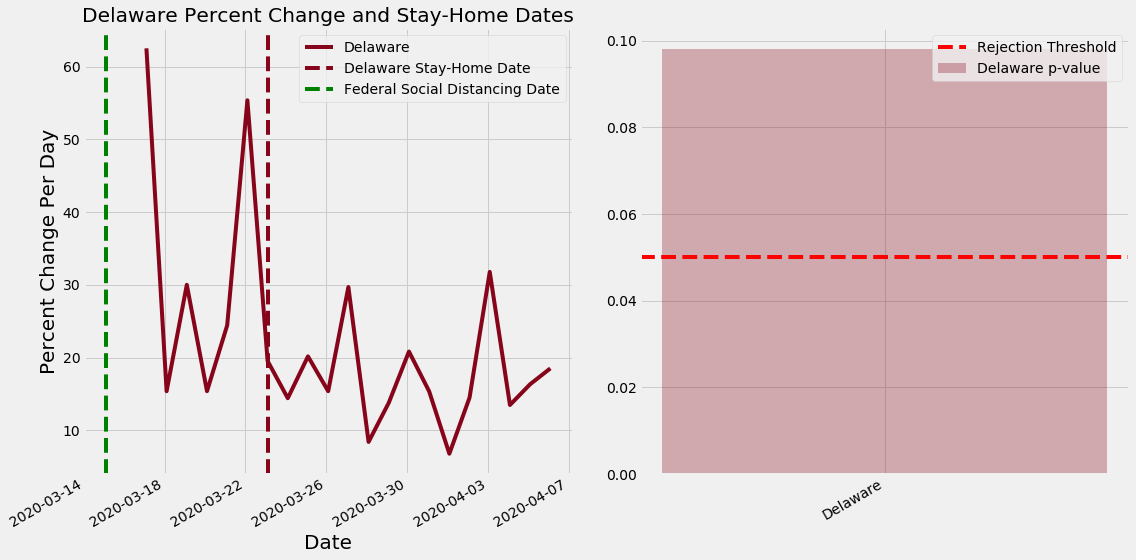

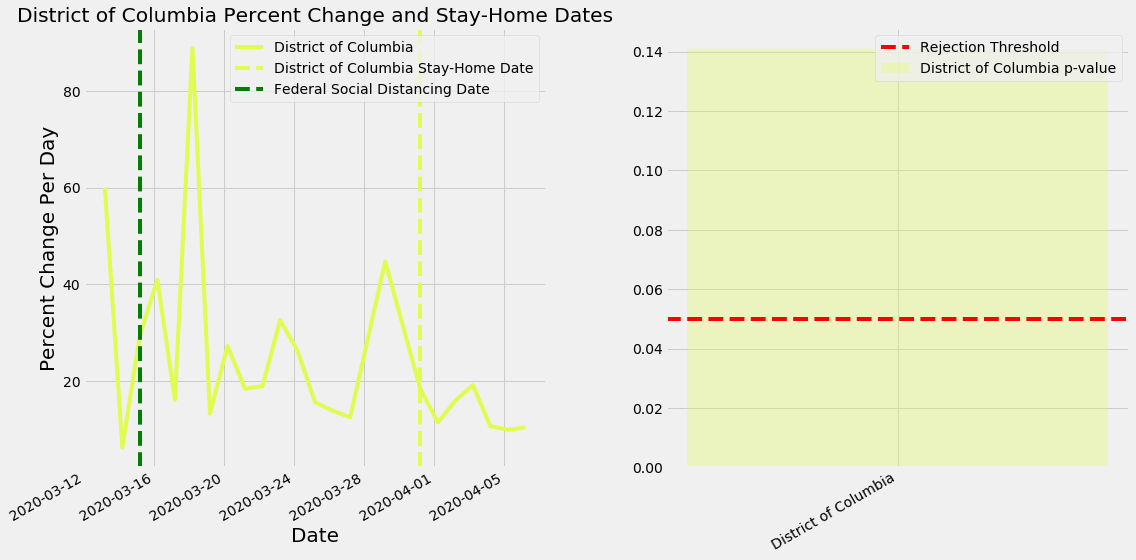

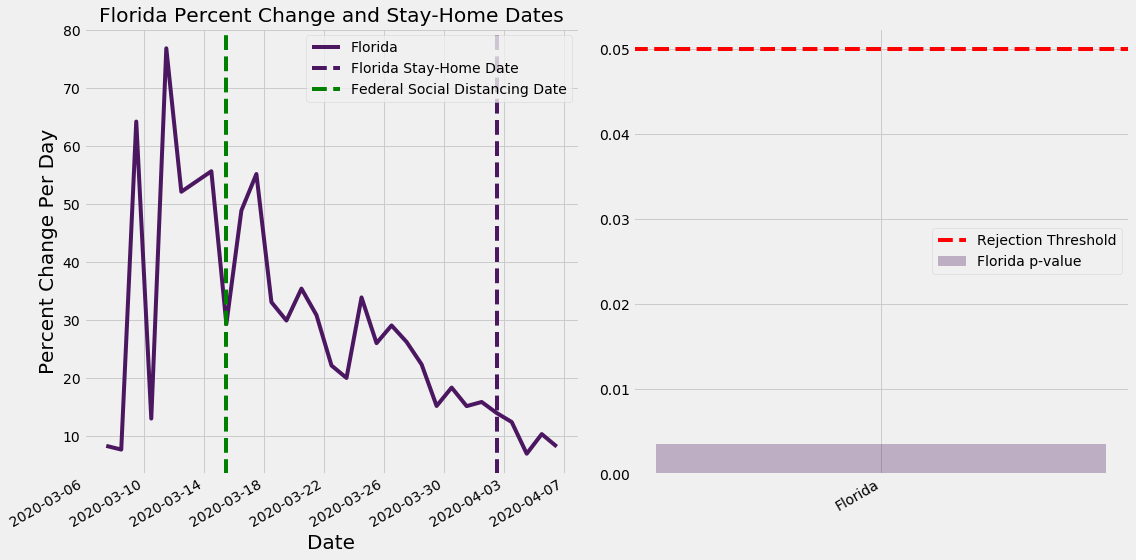

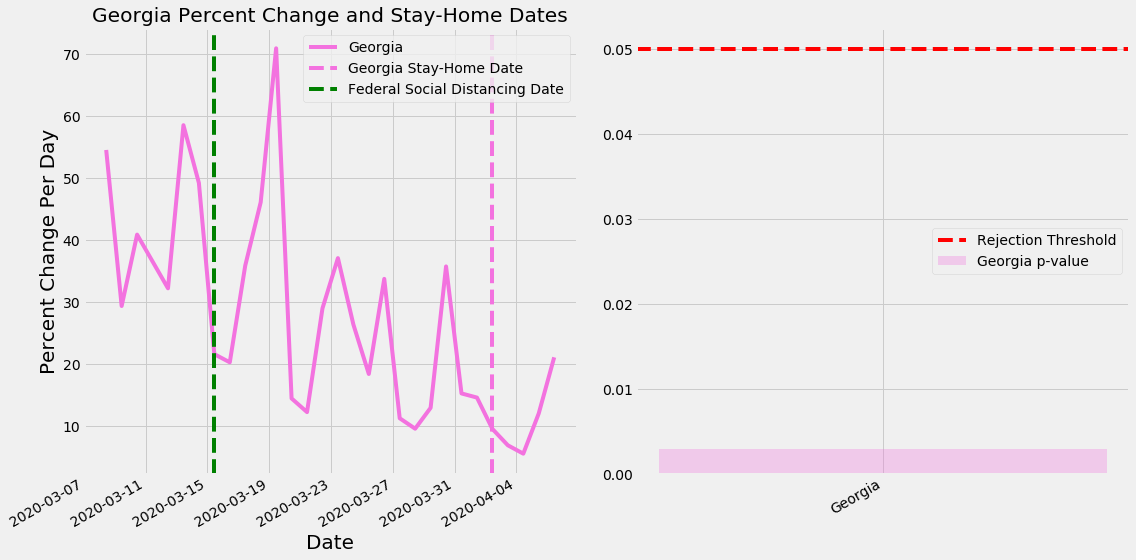

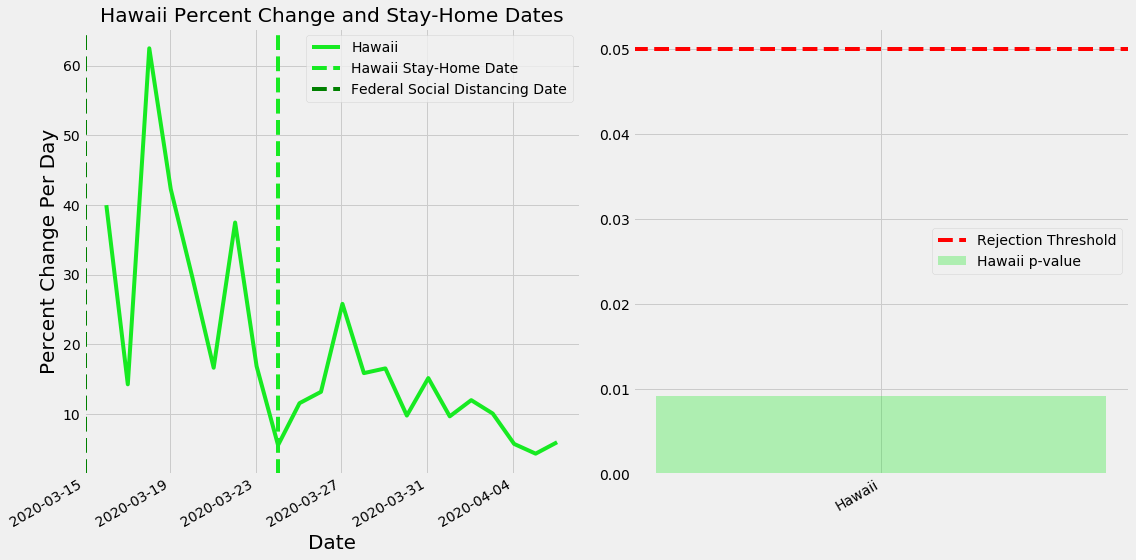

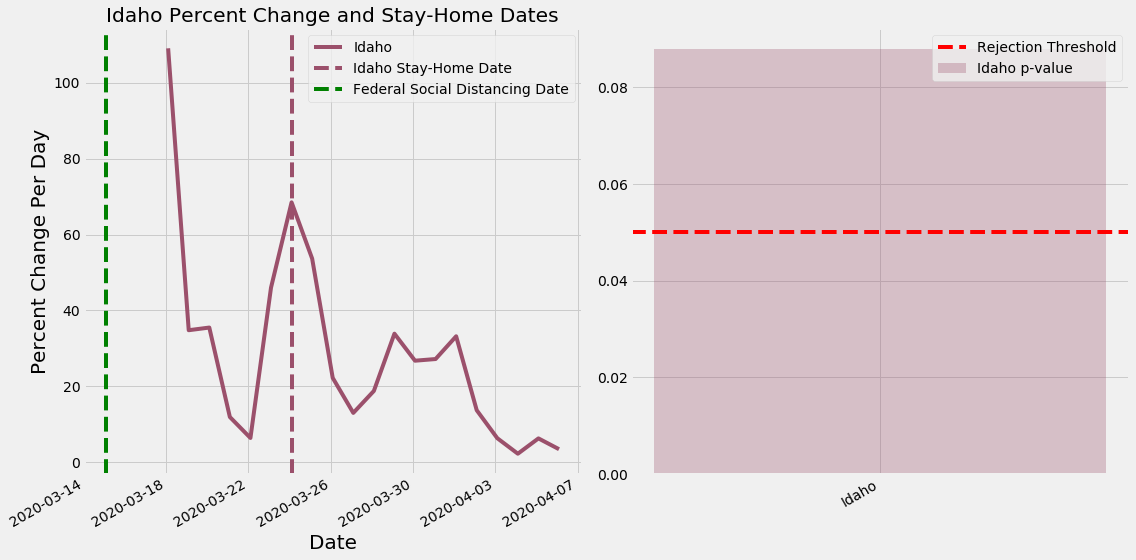

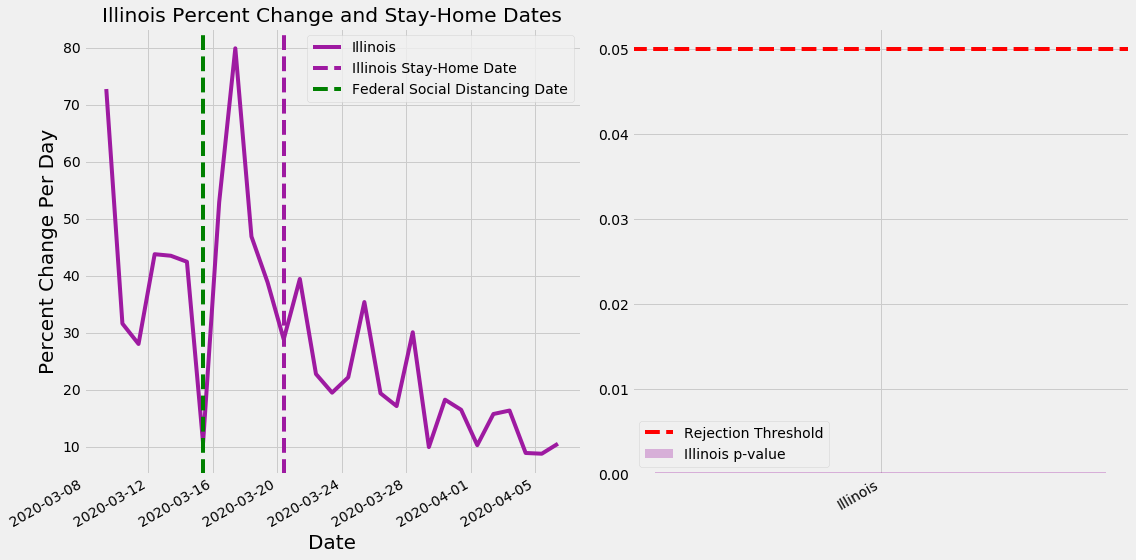

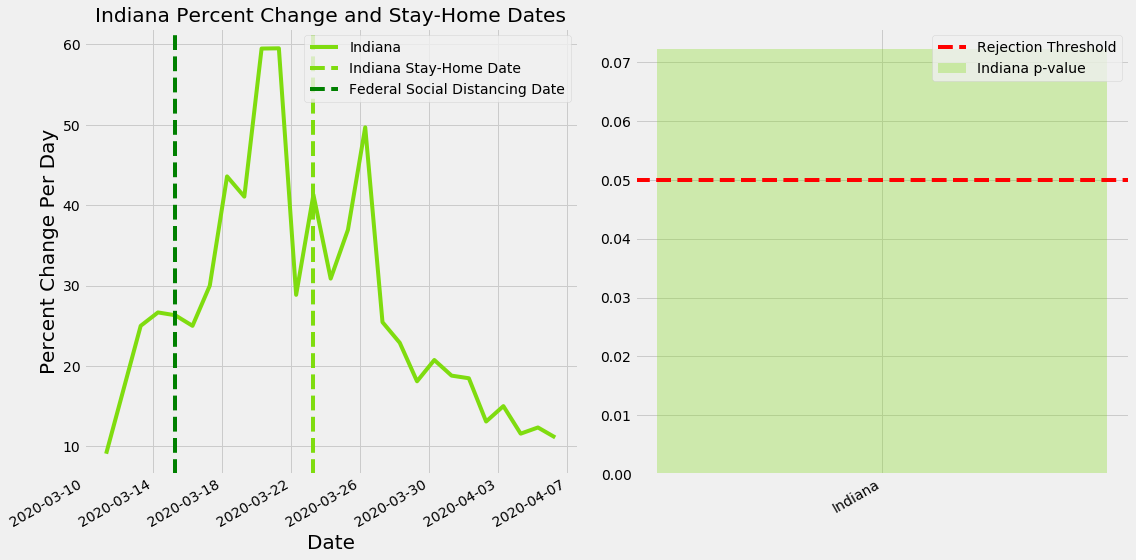

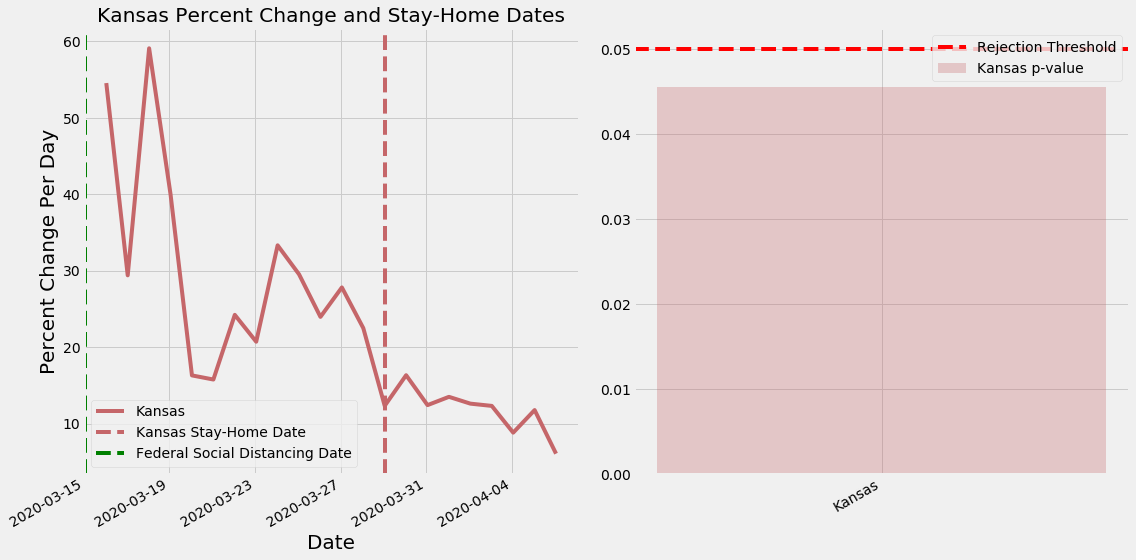

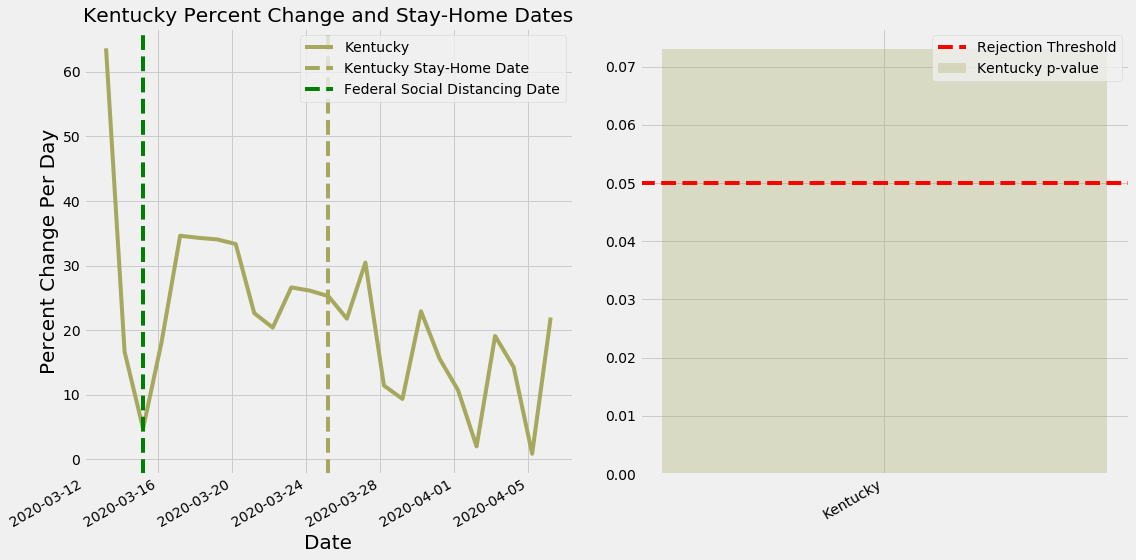

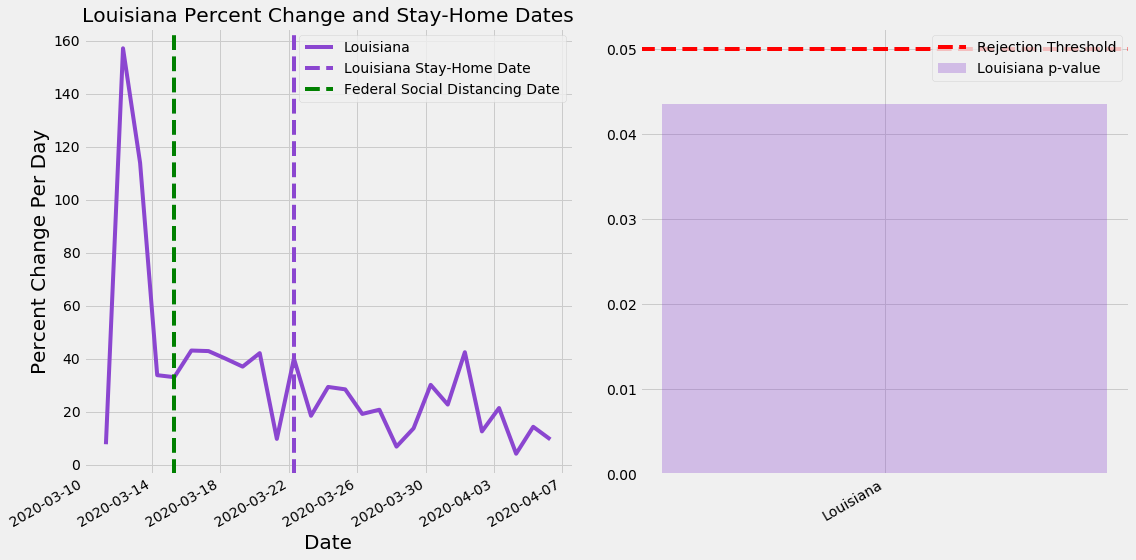

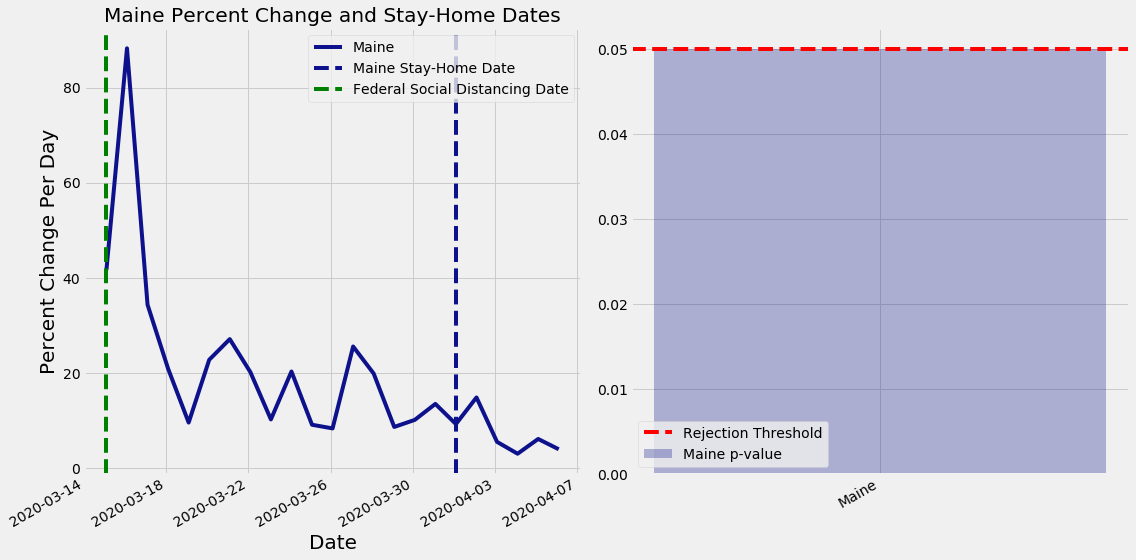

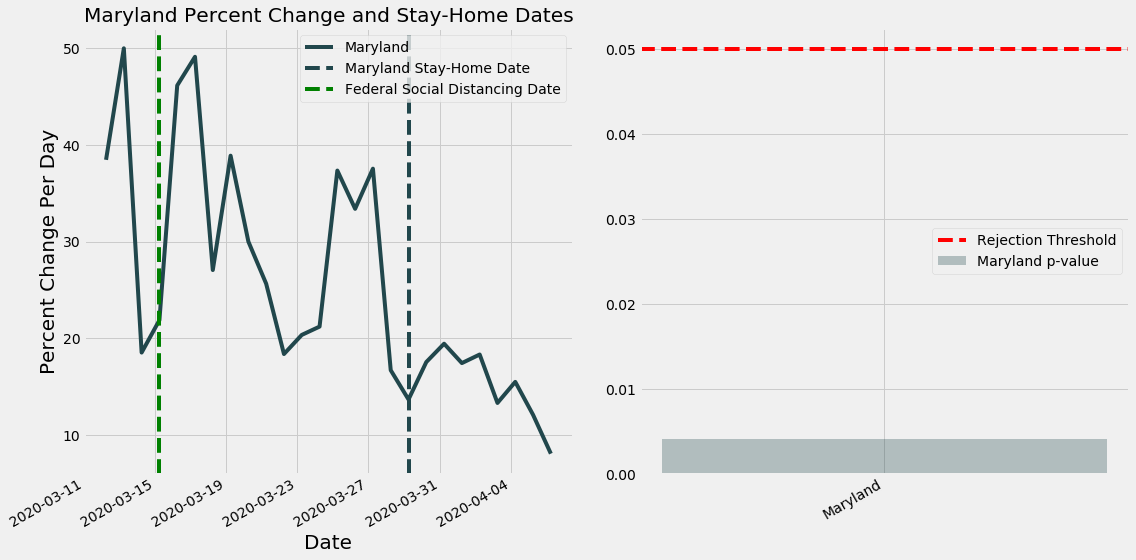

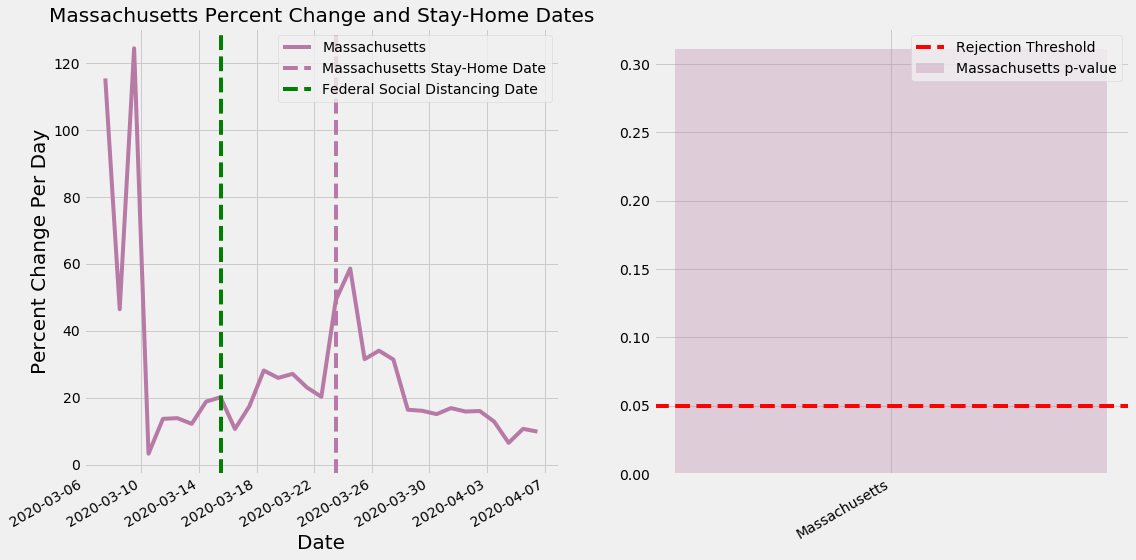

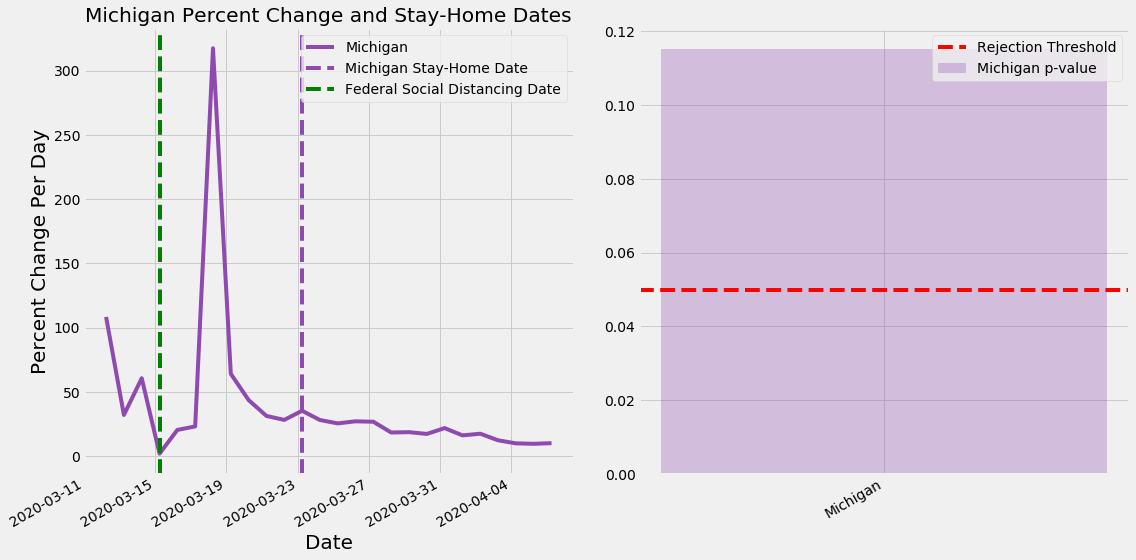

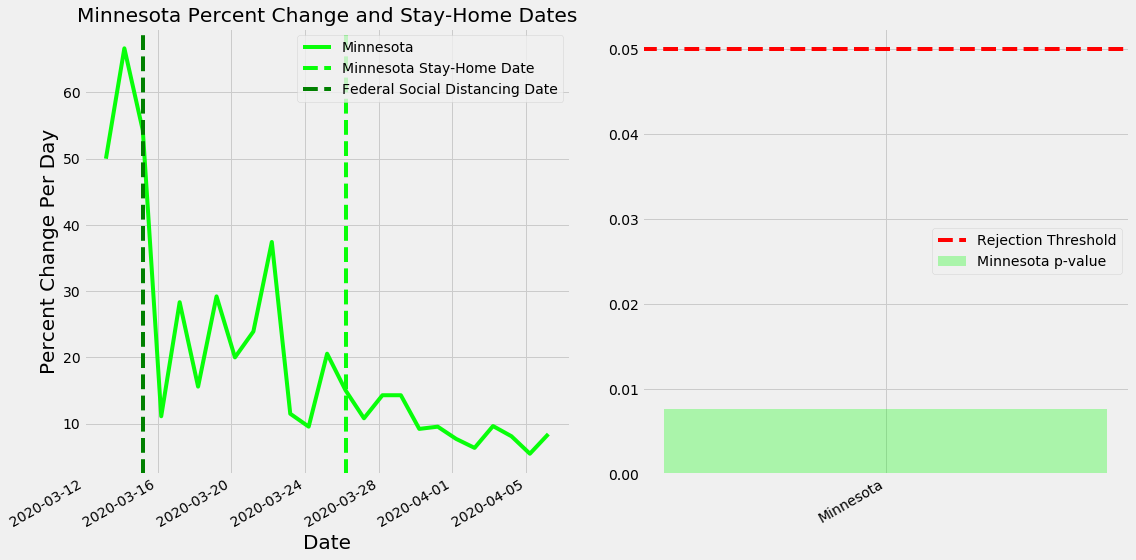

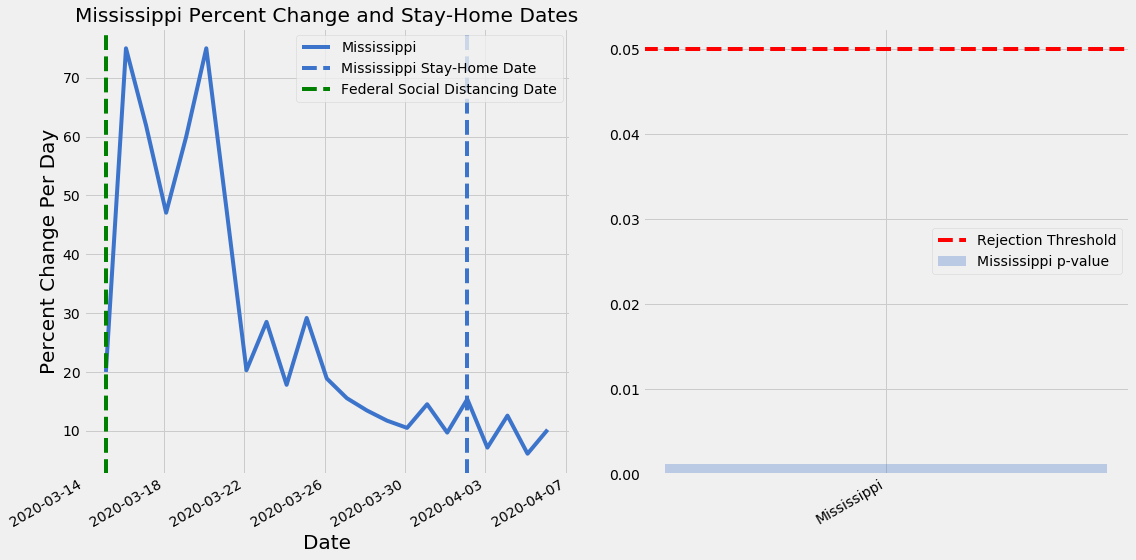

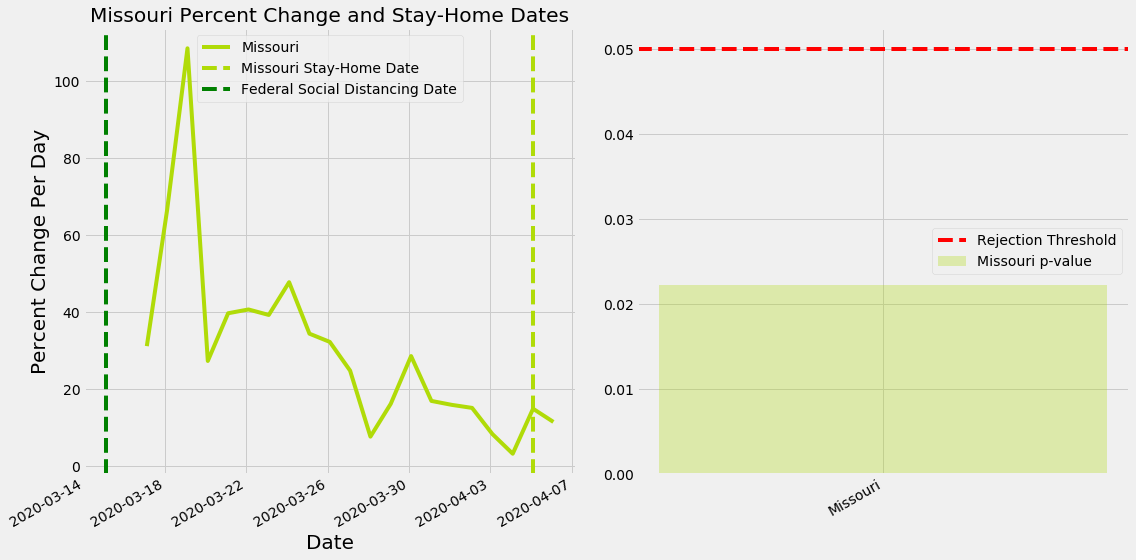

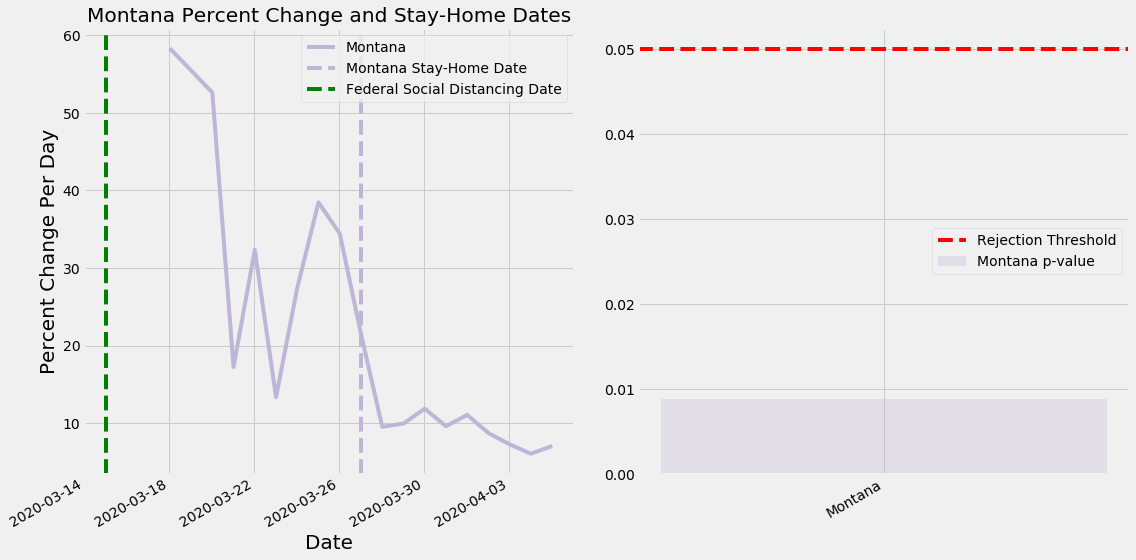

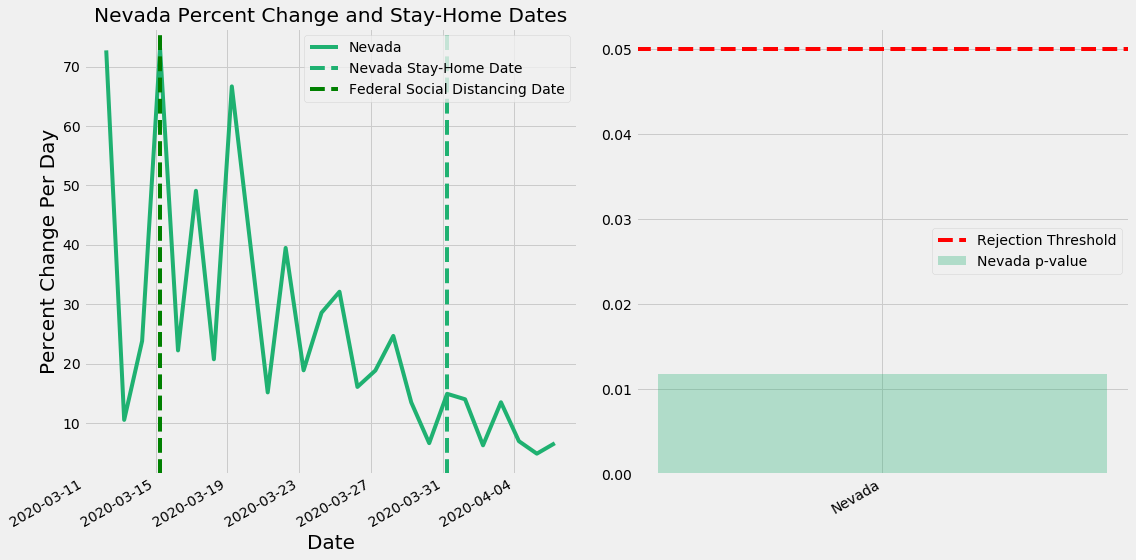

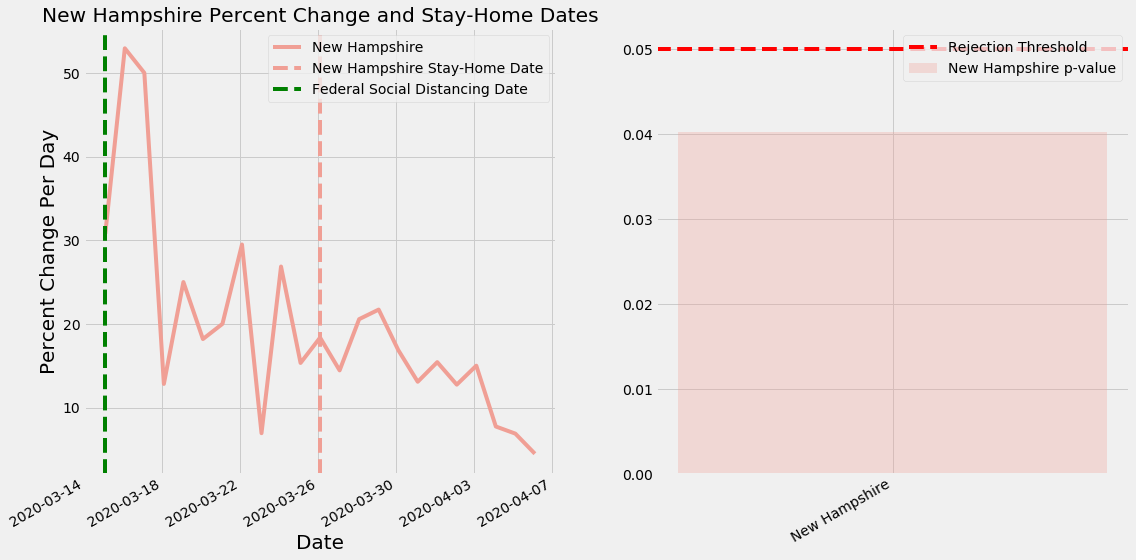

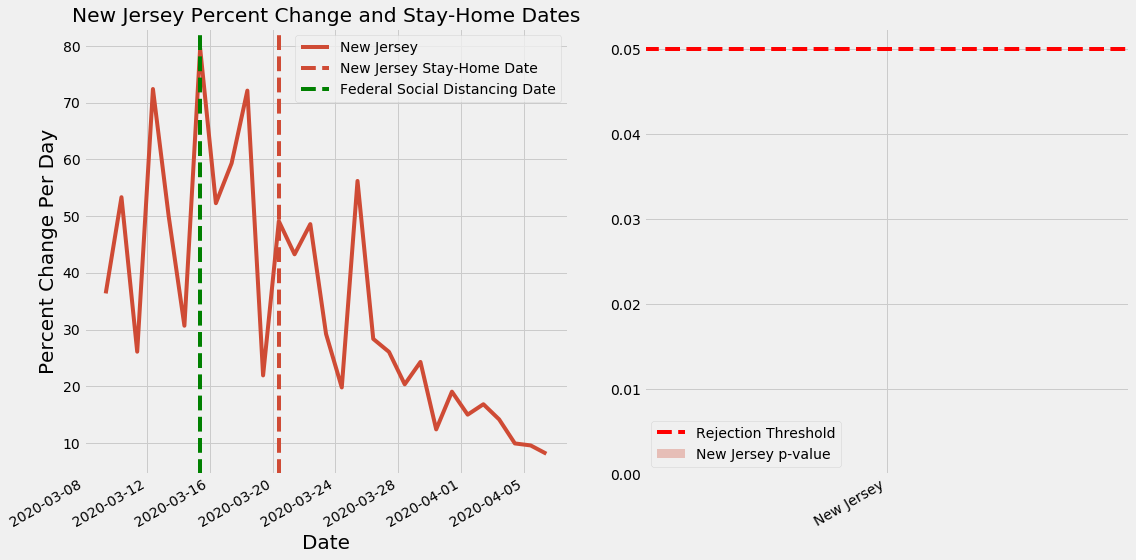

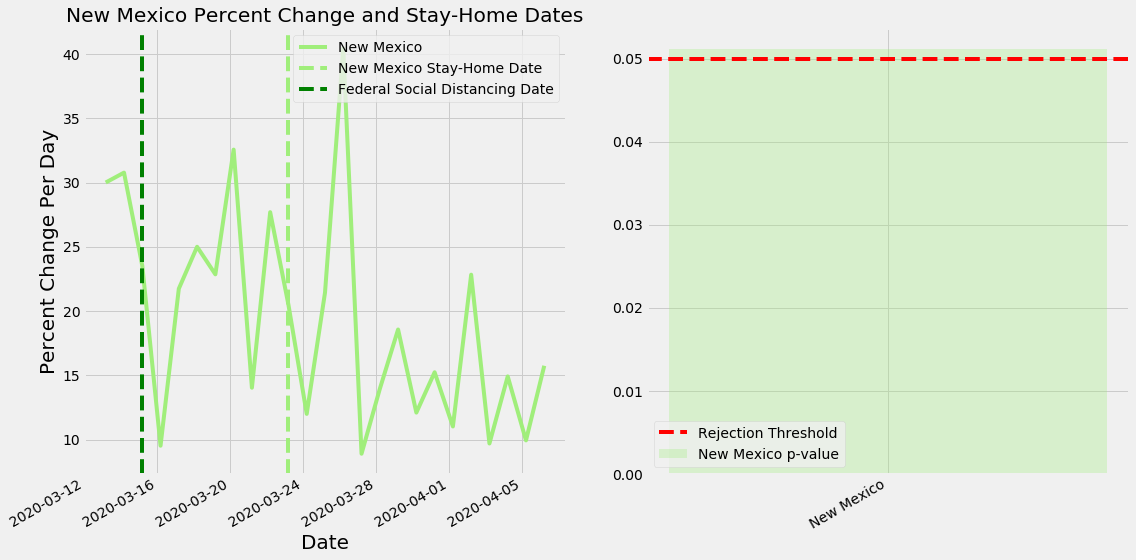

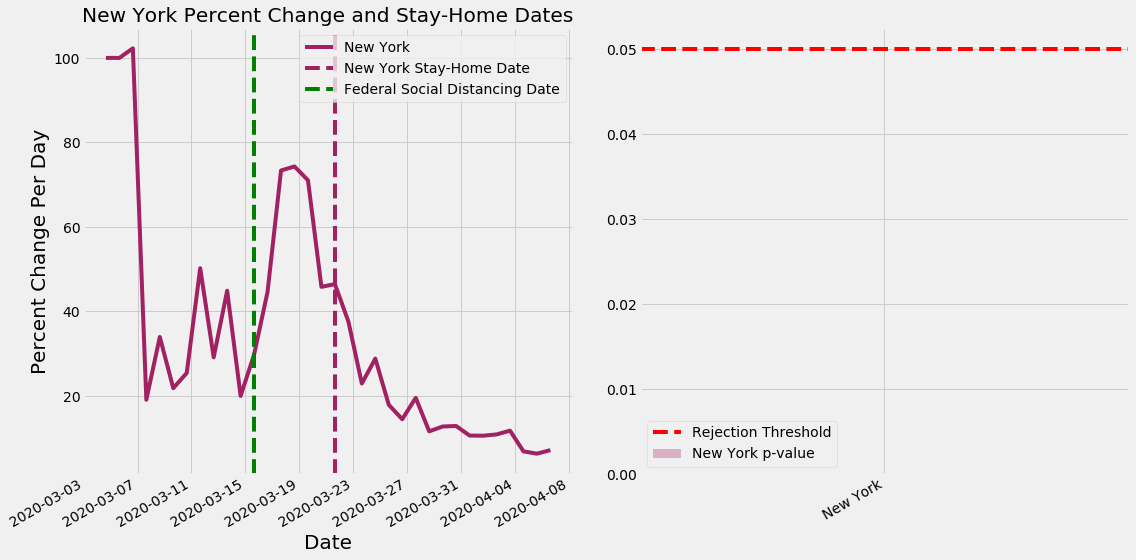

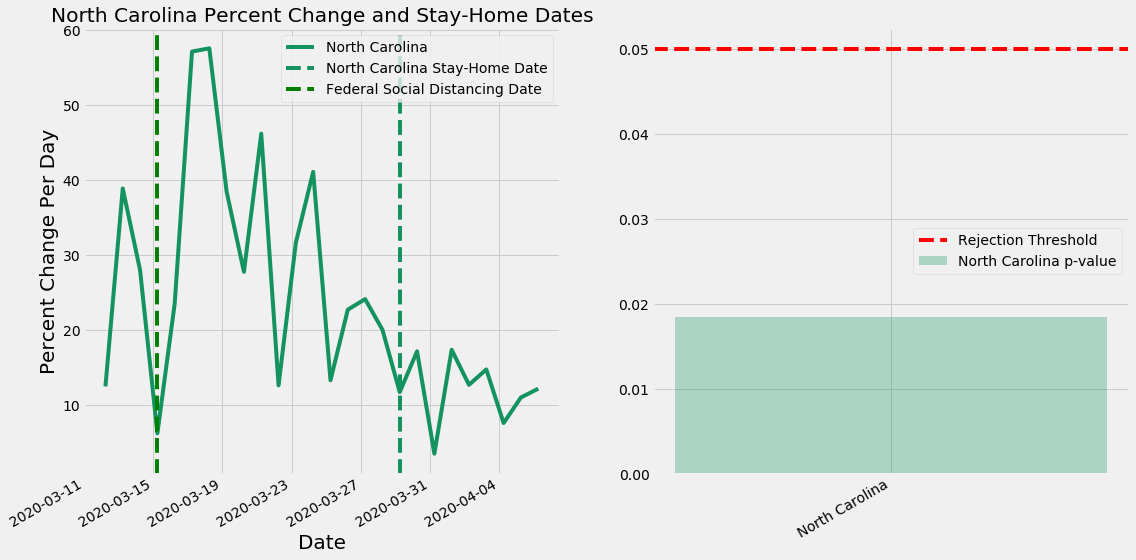

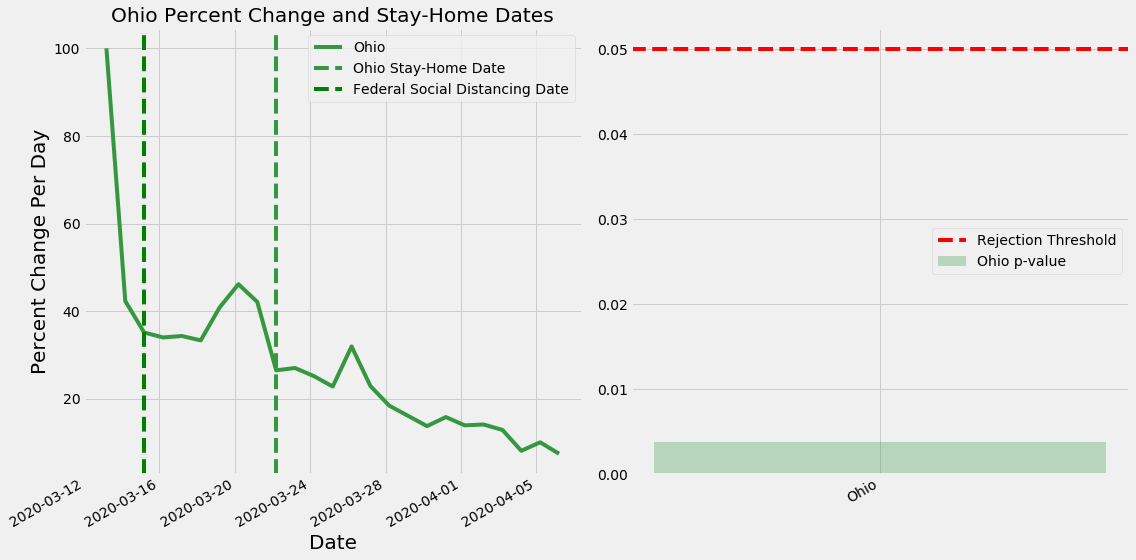

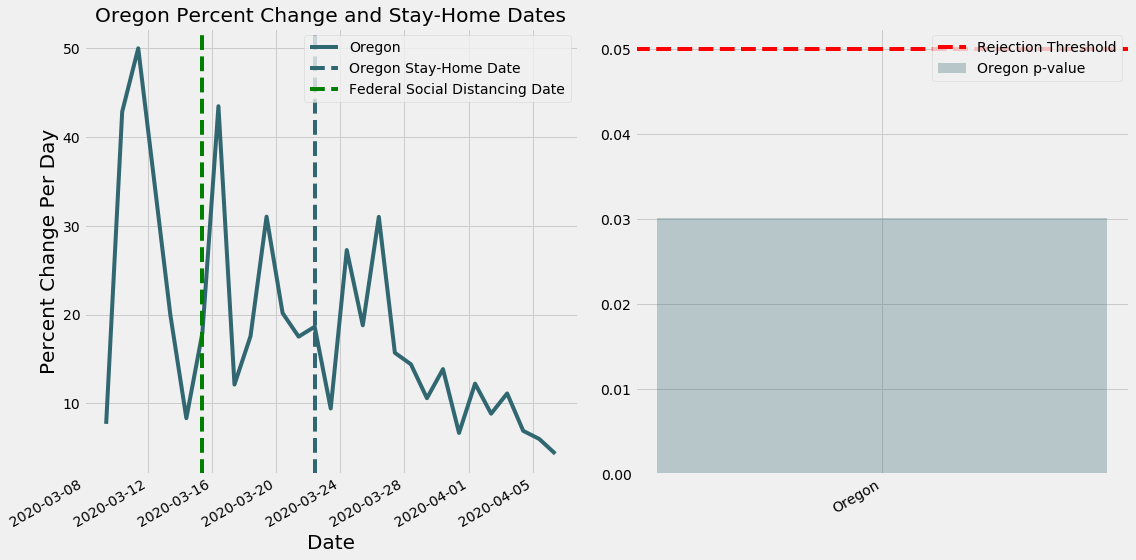

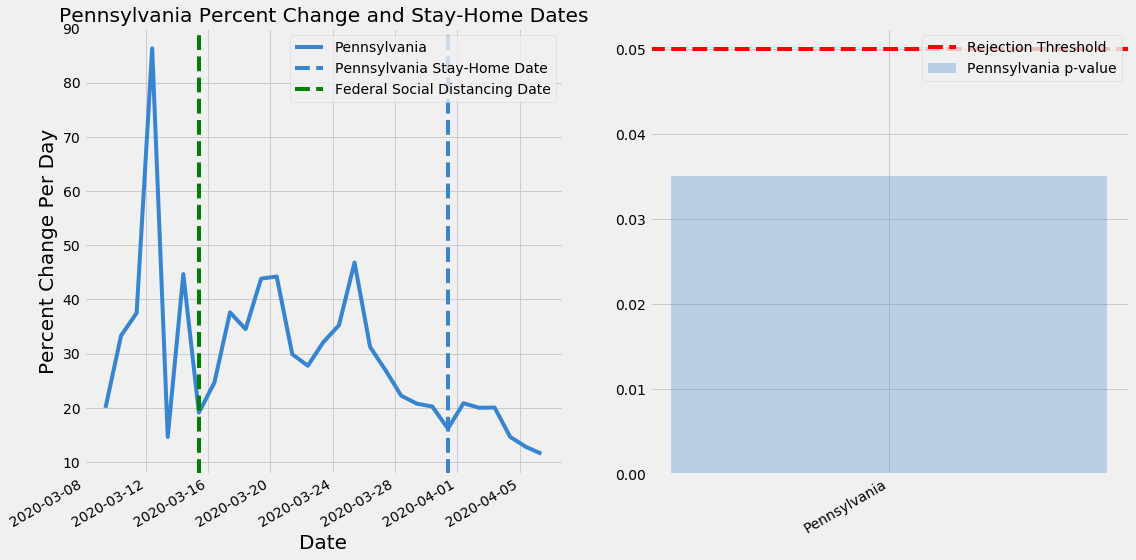

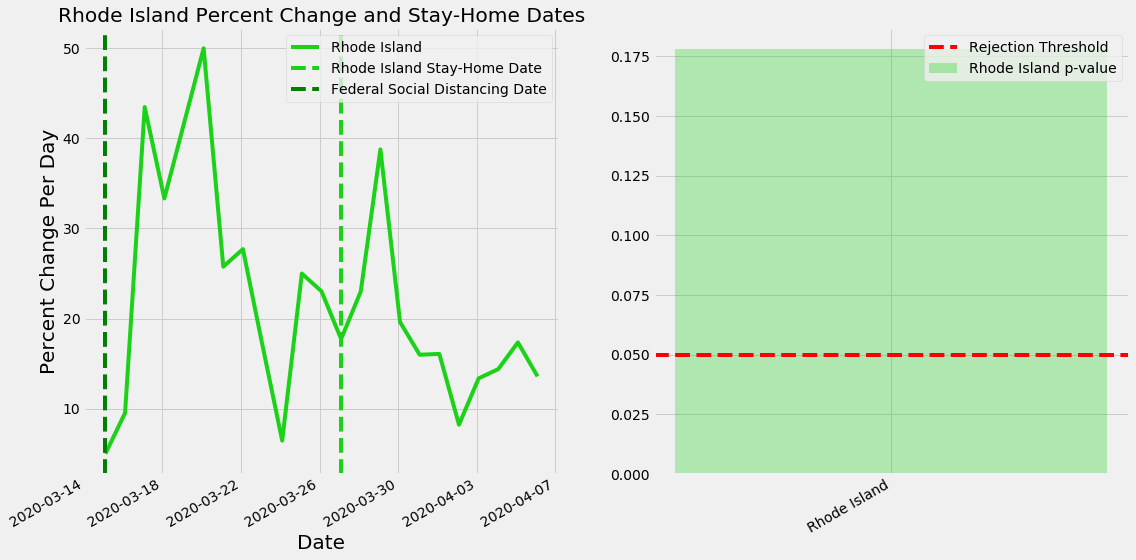

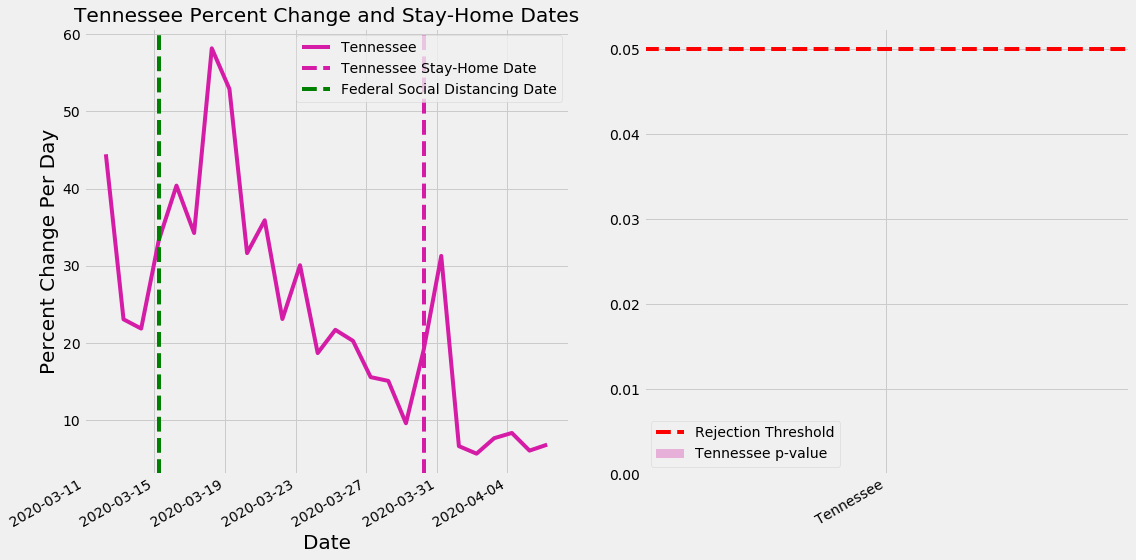

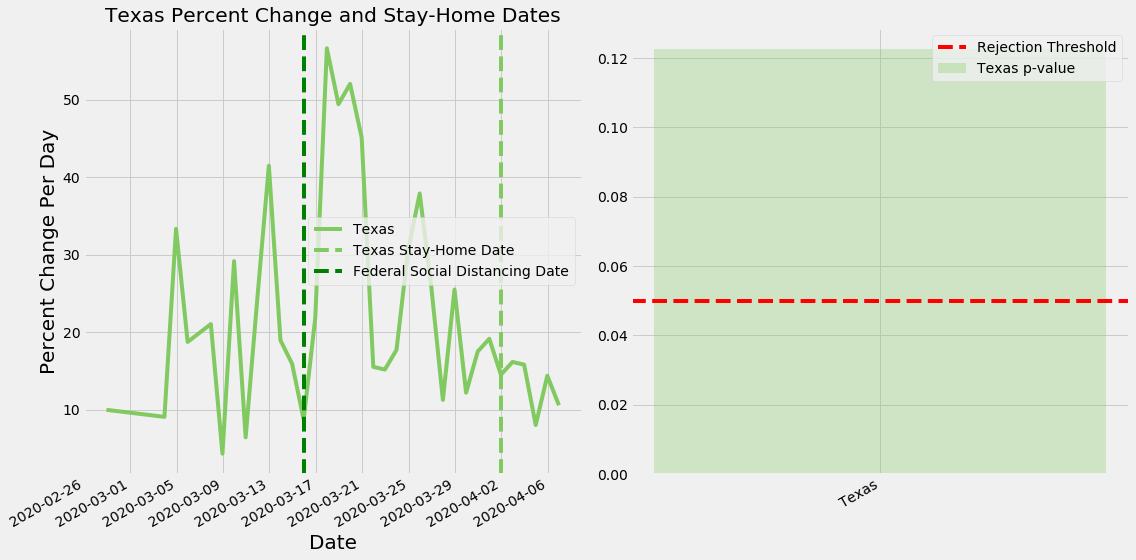

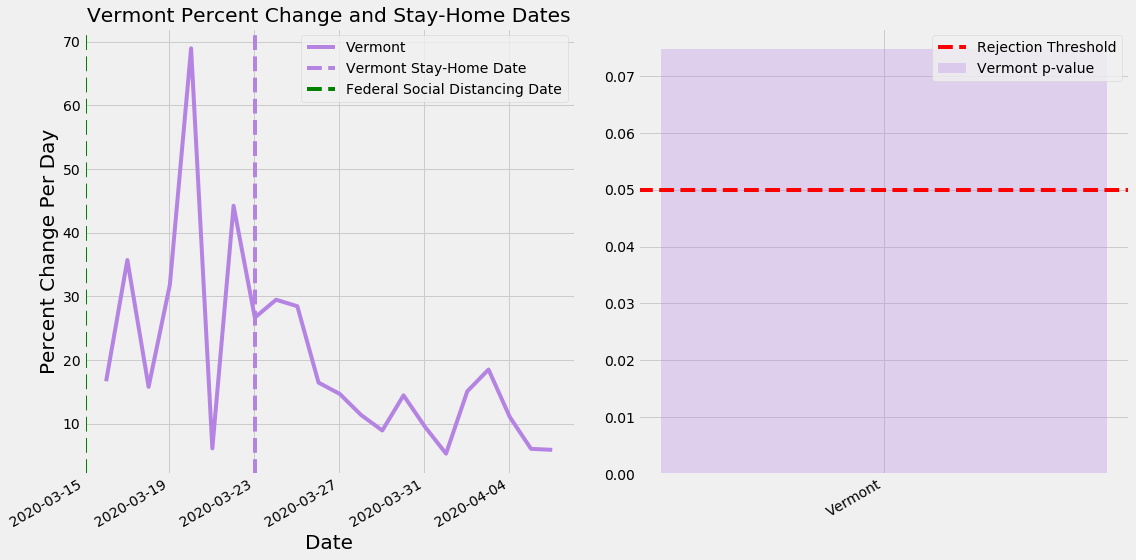

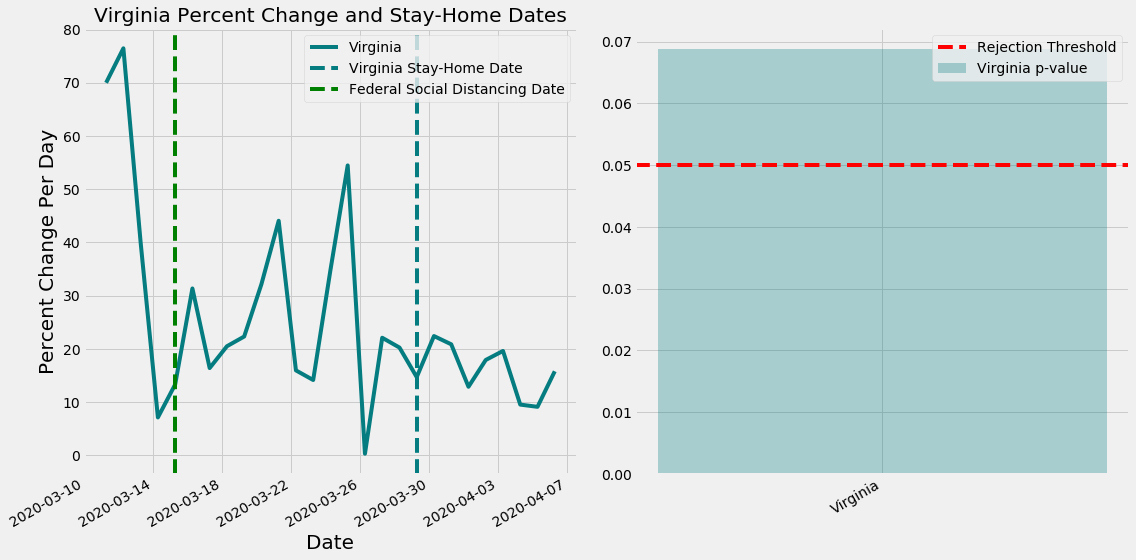

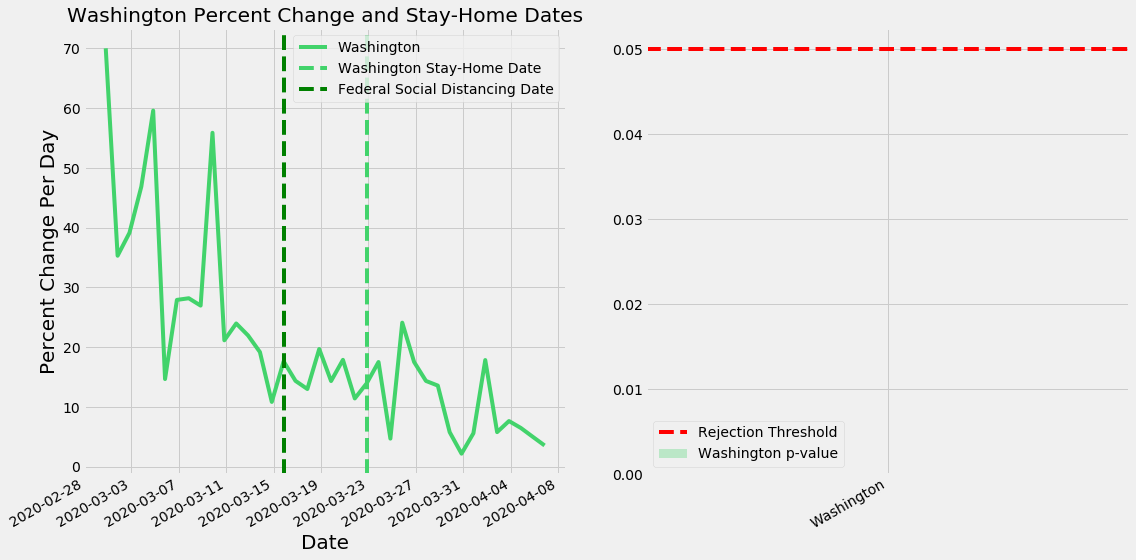

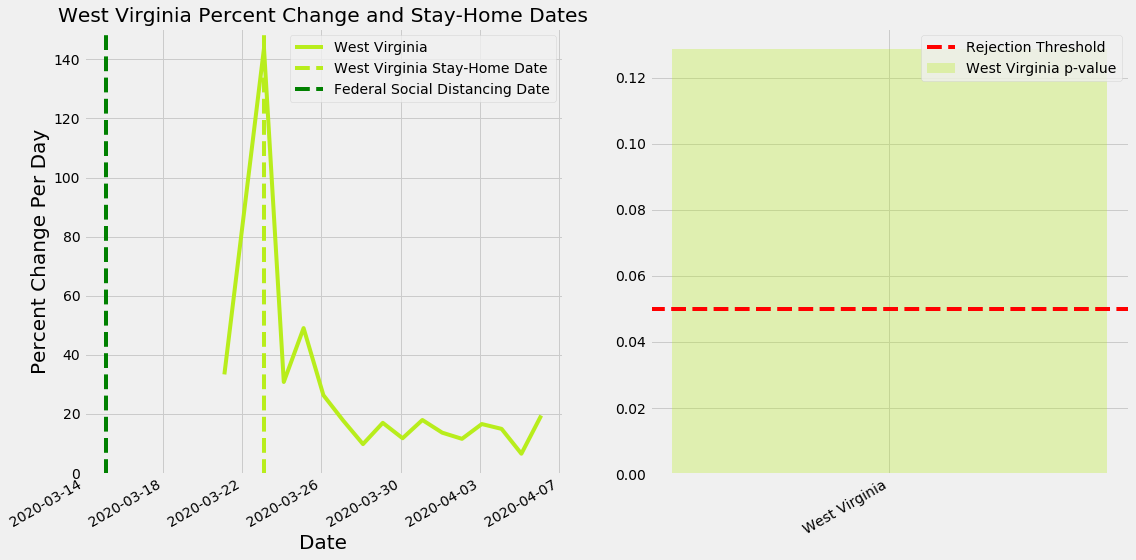

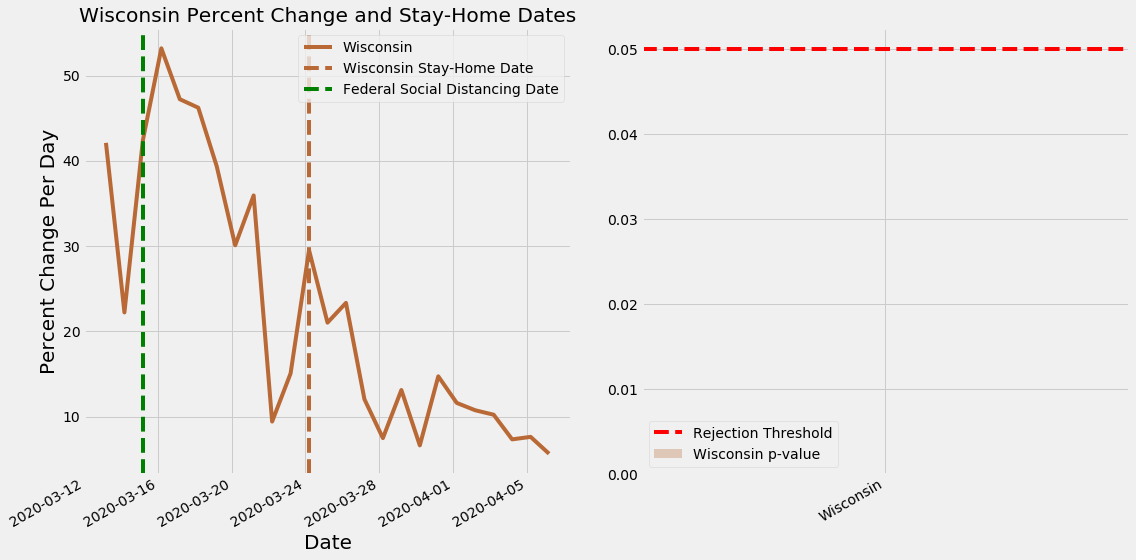

In [133]:
for each_state in all_states:
    i=0 #counter for the axes
    
    #generate a new plot to plot on
    fig, axs = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False)
    ax = axs.flatten()

    #plot percent change
    each_state.plot_percent_changes(ax[i])
    plot_social_distance(ax[i], get_social_distance_date())

    #plot bar graph next to percent change
    each_state.plot_p_value(ax[i+1])
    
    ax[i].set_title('{} Percent Change and Stay-Home Dates'.format(each_state.name))
    generate_labels(ax[i])
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.savefig('figures/{}_states_with_p_value.png'.format(each_state.name))

### Group states with higher than 0.05 p-values

In [118]:
states_reject = []
states_no_reject = []

for each_state in all_states:
    if each_state.p_value > 0.05:
        states_no_reject.append(each_state)
    else:
        states_reject.append(each_state)

#### Plot states that null hypothesis cannot be rejected.

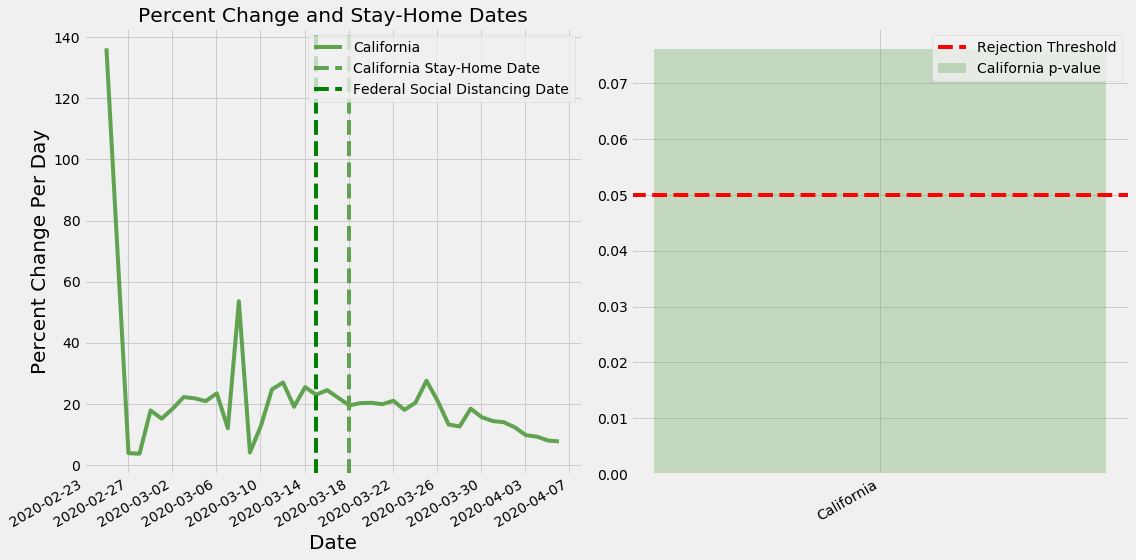

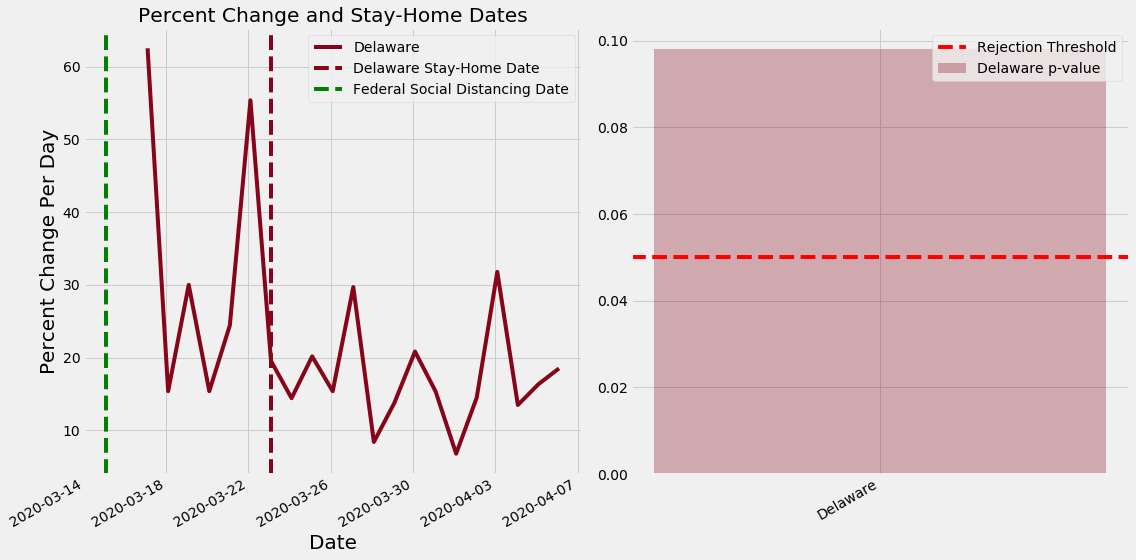

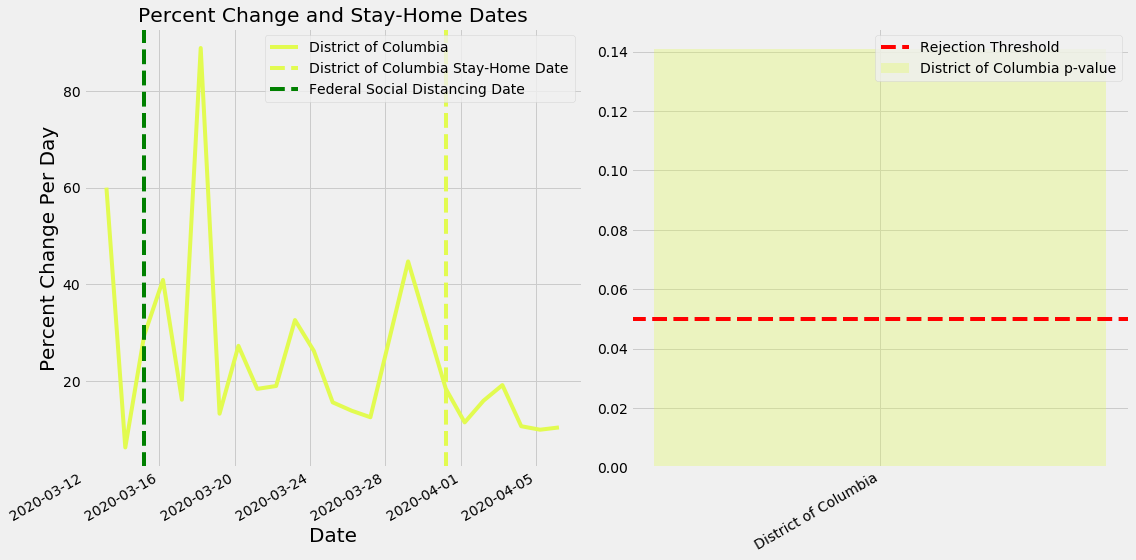

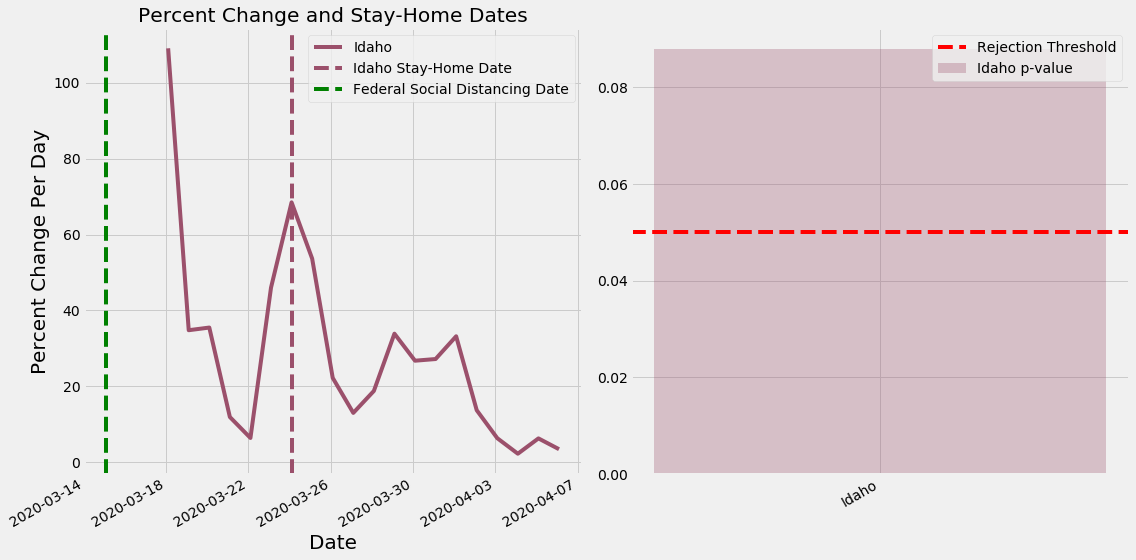

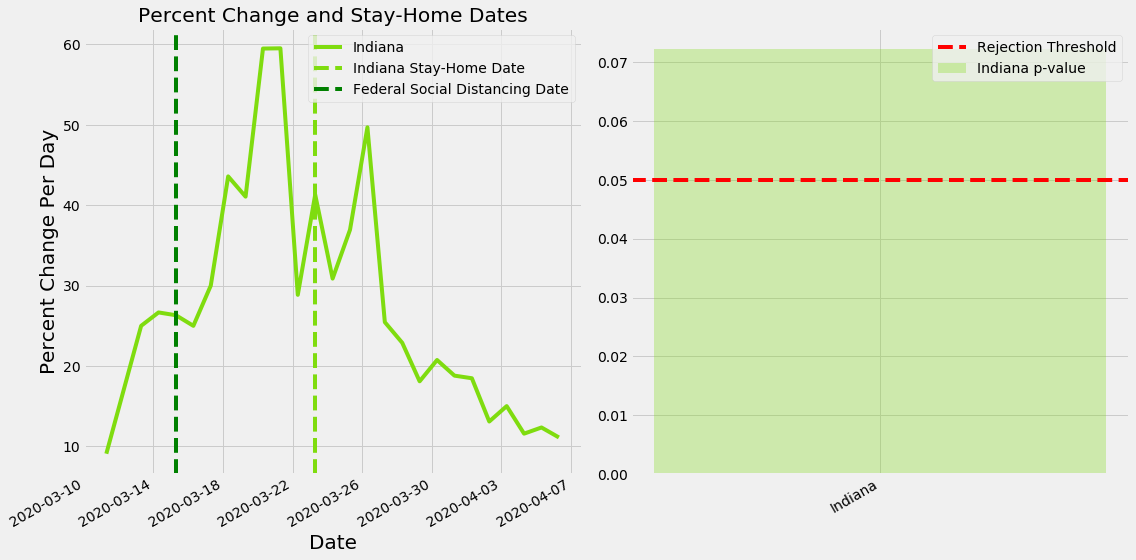

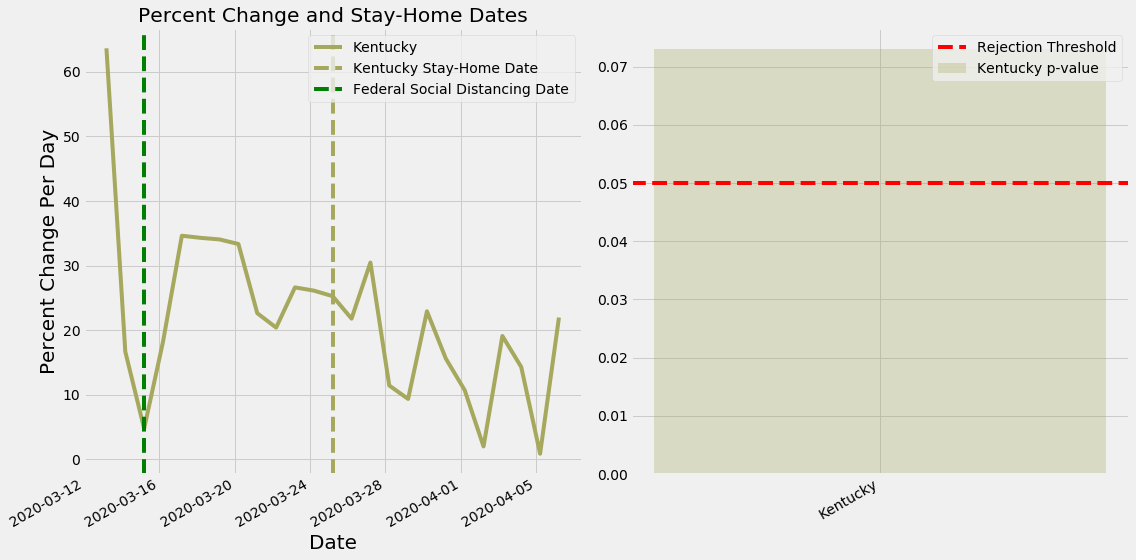

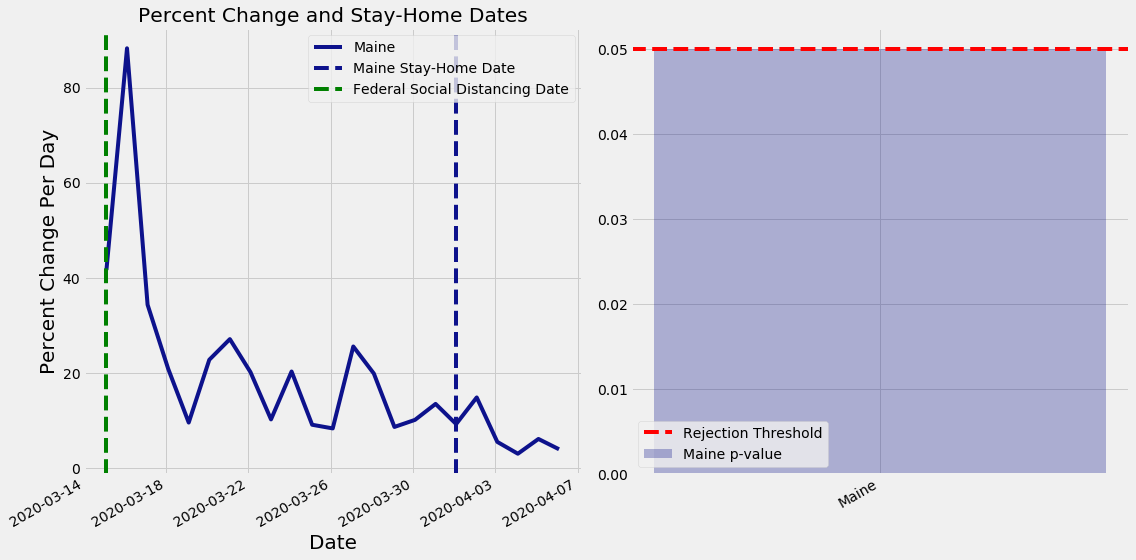

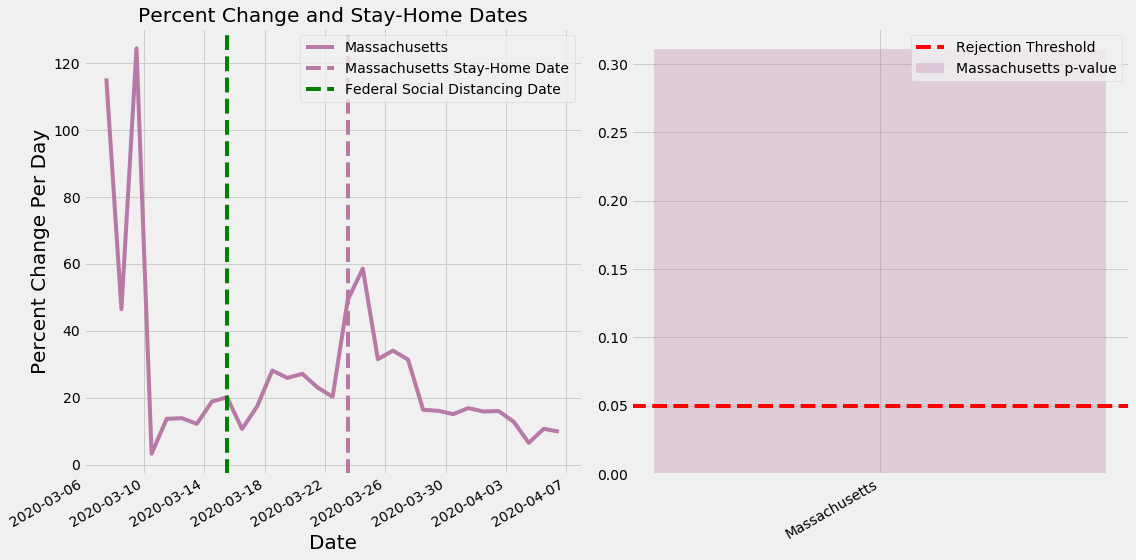

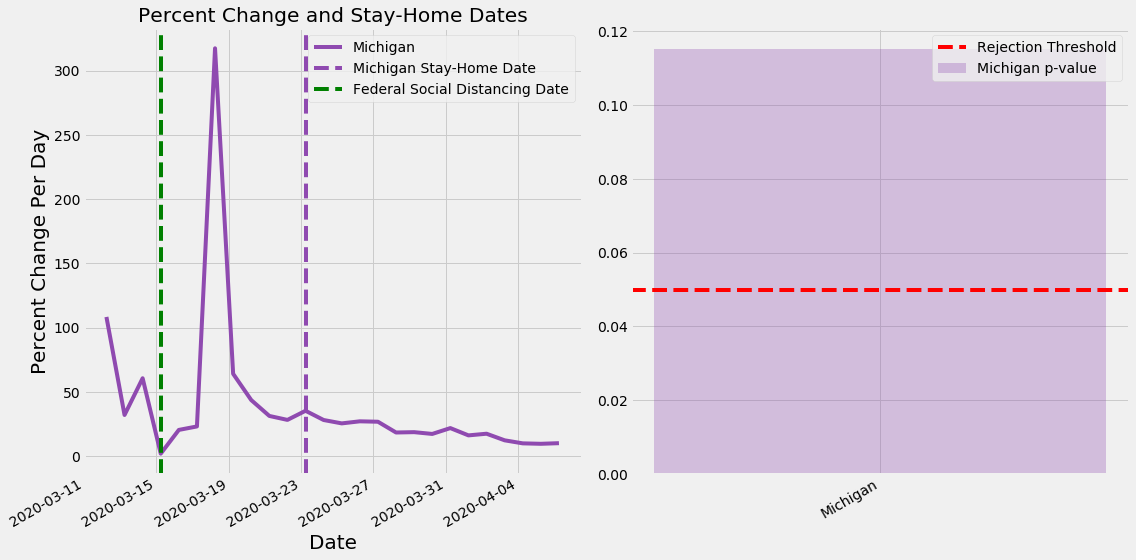

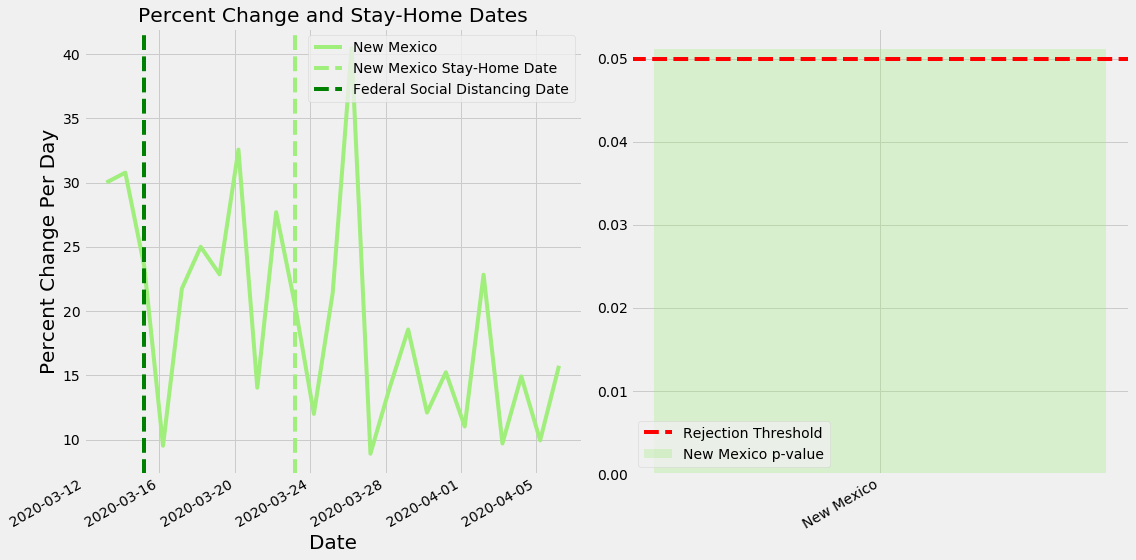

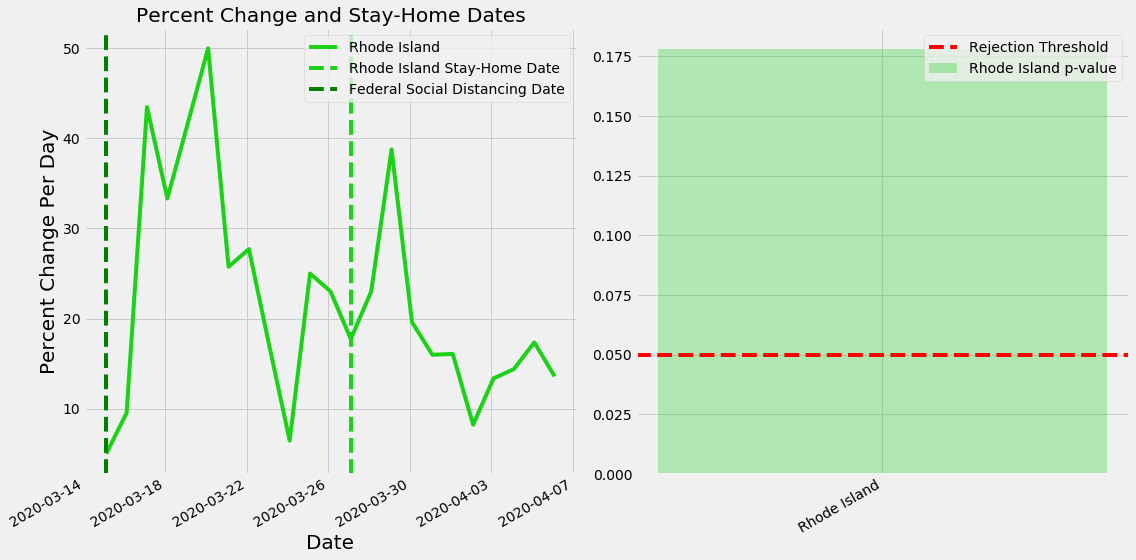

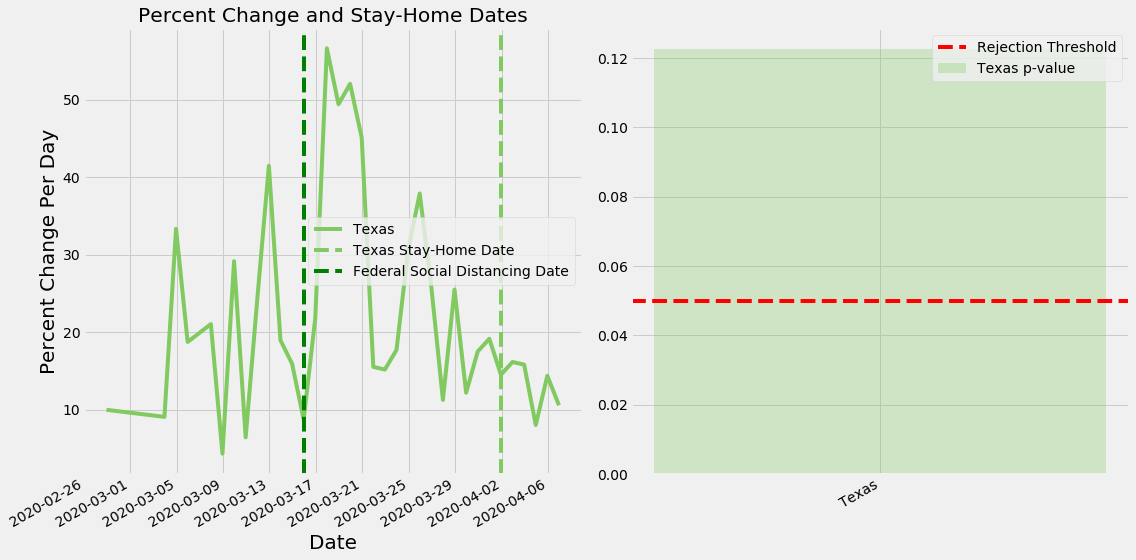

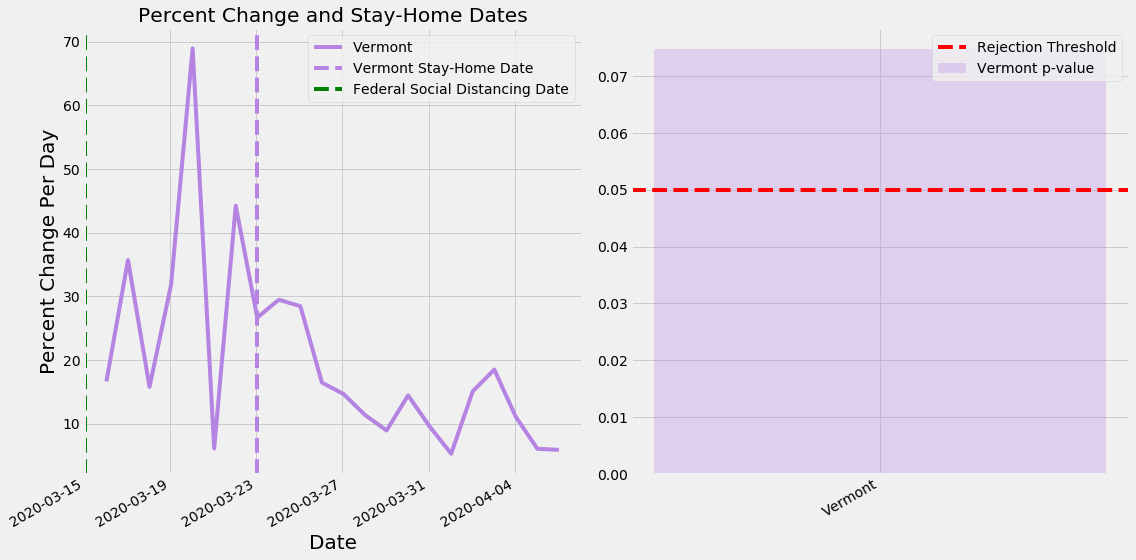

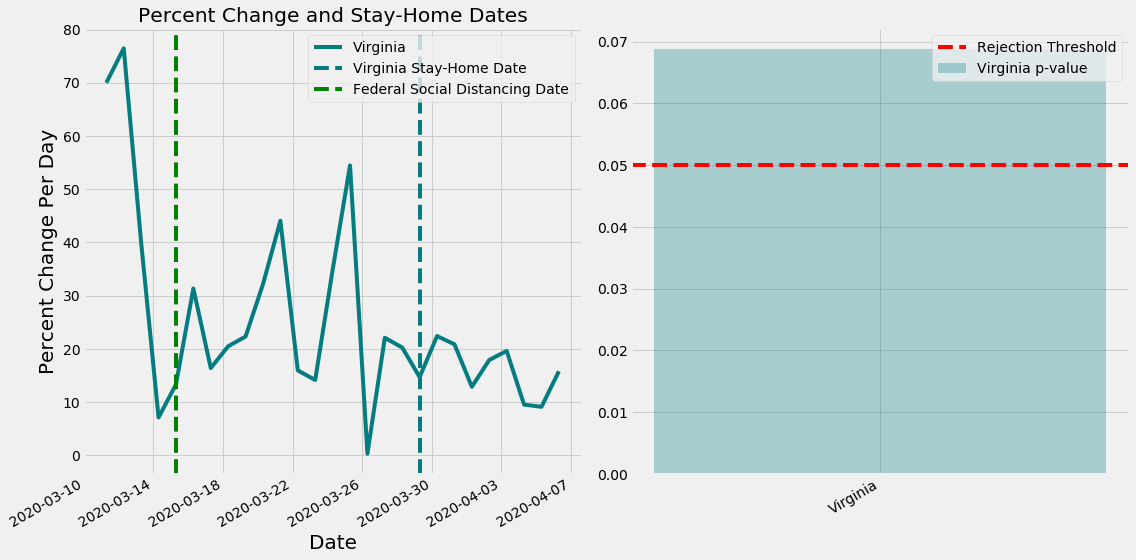

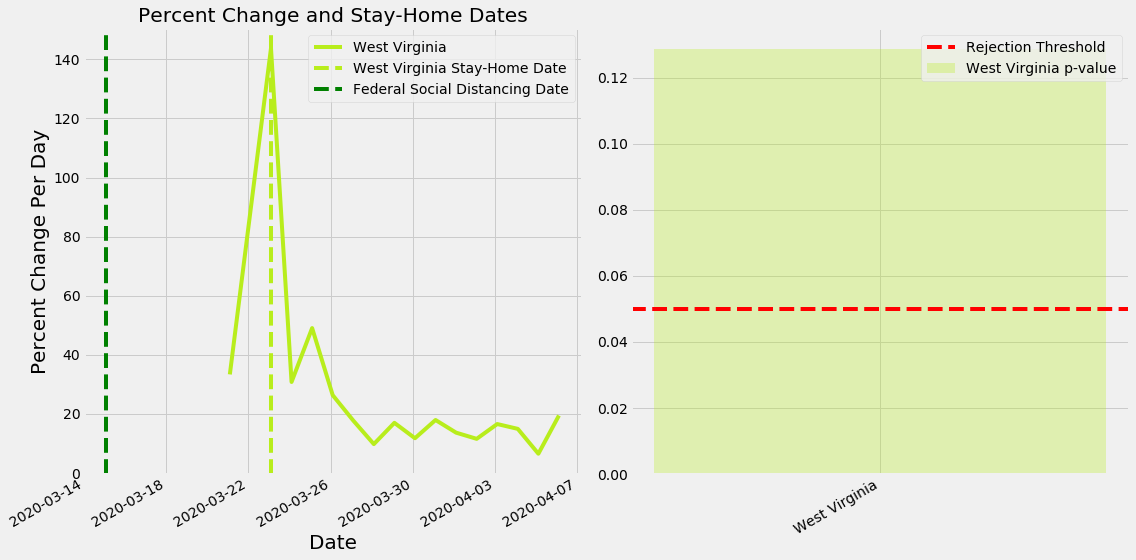

In [119]:
for each_state in states_no_reject:
    
    i = 0 #counter for the axes
    
    fig, axs = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False)
    ax = axs.flatten()
    
    #plot percent change
    each_state.plot_percent_changes(ax[i])
    plot_social_distance(ax[i], get_social_distance_date())
    generate_labels(ax[i])
    
    #plot bar graph next to percent change
    each_state.plot_p_value(ax[i+1])

    fig.tight_layout()

In [98]:
wash_ = []

for each_state in all_states:
    if each_state.name == 'Washington':
        wash_.append(each_state)

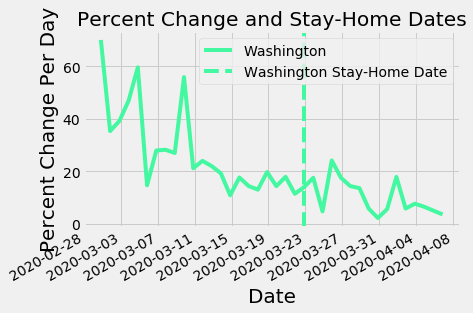

In [99]:
fig, ax = plt.subplots()
wash_[0].plot_percent_changes(ax)
generate_labels(ax)